**Dataset Overview**  
Dataset 1B details:  
- date : date of the assessment.
- quarter : the quarter of the year when the data was recorded.
- day : day of the week
- Team Code : a unique identifier for the team.
- smv : Standard Minute Value, a measure of the time allocated for a task.
- wip : Work In Progress, the number of products that are unfinished.
- over_time : the amount of overtime worked, measured in minutes.
- incentive : the incentive provided to the workers, measured in USD.
- idle_time : the amount of time workers were idle, measured in minutes.
- idle_men : the number of workers who were idle.
- no_of_style_change: the number of style changes that occurred.
- no_of_workers : the total number of workers.
- productivity_score : the productivity score of the team, measured as a percentage.

#### **IMPORT LIBRARIES AND SET SEED**

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import shapiro

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1, l2

SEED = 7
np.random.seed(SEED)
tf.keras.utils.set_random_seed(SEED)

print("All libraries imported.")

All libraries imported.


#### **DATA PREPROCESSING AND EDA**

##### **READ AND EXPLORE DATA**

In [2]:
data = pd.read_parquet("./Dataset/dataset_1B.parquet")
data.head(10)

,date,quarter,day,Team Code,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,productivity_score
0,1/1/2015,Quarter1,Thursday,8,26.16,1108.0,7080,98,0.0,0,0,59.0,94.073
1,1/1/2015,Quarter1,Thursday,1,3.94,NaN,960,0,0.0,0,0,8.0,88.650
2,1/1/2015,Quarter1,Thursday,11,11.41,968.0,3660,50,0.0,0,0,30.5,80.057
3,1/1/2015,Quarter1,Thursday,12,11.41,968.0,3660,50,0.0,0,0,30.5,80.057
4,1/1/2015,Quarter1,Thursday,6,25.90,1170.0,1920,50,0.0,0,0,56.0,80.038
5,1/1/2015,Quarter1,Thursday,7,25.90,984.0,6720,38,0.0,0,0,56.0,80.012
6,1/1/2015,Quarter1,Thursday,2,3.94,NaN,960,0,0.0,0,0,8.0,75.517
7,1/1/2015,Quarter1,Thursday,3,28.08,795.0,6900,45,0.0,0,0,57.5,75.368
8,2016-01-01,Quarter1,Thursday,2,19.87,733.0,6000,34,0.0,0,0,55.0,75.310
9,2016-01-01,Quarter1,Thursday,1,28.08,681.0,6900,45,0.0,0,0,57.5,75.043


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                1197 non-null   object 
 1   quarter             1197 non-null   object 
 2   day                 1197 non-null   object 
 3   Team Code           1197 non-null   int64  
 4   smv                 1197 non-null   float64
 5   wip                 691 non-null    float64
 6   over_time           1197 non-null   int64  
 7   incentive           1197 non-null   int64  
 8   idle_time           1197 non-null   float64
 9   idle_men            1197 non-null   int64  
 10  no_of_style_change  1197 non-null   int64  
 11  no_of_workers       1197 non-null   float64
 12  productivity_score  1197 non-null   float64
dtypes: float64(5), int64(5), object(3)
memory usage: 121.7+ KB


> Based on the output above, the date column has some inconsistent formats, so it needs to be standardized.  
> Additionally, the *wip* column also has missing values, which is an aspect that needs to be addressed before building the model.

##### **MISSING VALUES**

In [4]:
def check_missing(data):
    missing = pd.DataFrame({
        "column name" : data.columns.tolist(),
        "missing values": data.isnull().sum().tolist(),
        "percentage": ((data.isnull().sum()) * 100 / len(data)).round(2).tolist()
    })

    print("Missing Values Check Result:")
    display(missing)

check_missing(data)

Missing Values Check Result:


,column name,missing values,percentage
0,date,0,0.00
1,quarter,0,0.00
2,day,0,0.00
3,Team Code,0,0.00
4,smv,0,0.00
5,wip,506,42.27
6,over_time,0,0.00
7,incentive,0,0.00
8,idle_time,0,0.00
9,idle_men,0,0.00


> Based on the table above and the insights from the [**READ AND EXPLORE DATA**](#READ-AND-EXPLORE-DATA) section, it is known that the *wip* column has missing values accounting for 42.27% of the total data—a significant portion. Therefore, handling this requires careful attention, as either dropping or imputing the values without further analysis could introduce bias or even lead to the loss of valuable information for the model later.

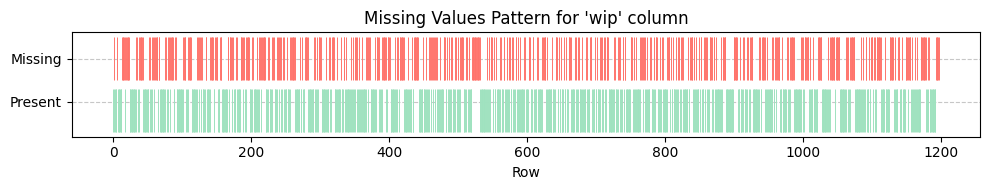

In [5]:
def na_pattern_plot(data, column, figsize = (10, 2)):
    na_mask = data[column].isna()
    fig, ax = plt.subplots(figsize = figsize)
    ax.vlines(data.index[na_mask], 
              ymin = 0.5, 
              ymax = 1.5, 
              linewidth = 0.7,
              colors = "#FF746C", 
              label = "Missing")
    ax.vlines(data.index[~na_mask],
              ymin = -0.7,
              ymax = 0.3,
              linewidth = 0.7,
              colors = "#9FE2BF",
              label = "Present")
    ax.set_yticks([0, 1])
    ax.set_yticklabels(["Present", "Missing"])
    ax.set_xlabel("Row")
    ax.set_title(f"Missing Values Pattern for '{column}' column")
    ax.grid(True,
            axis = "y",
            linestyle = "--",
            alpha = 0.7)
    plt.tight_layout()
    plt.show()

na_pattern_plot(data, "wip")

> From the missing value pattern plot above, we can see that the missing values occur randomly, so there is no specific pattern to infer.  
> For further analysis, we need to determine whether this *wip* feature is important for predicting the *productivity_score*.

In [6]:
wip_prod = data.groupby(data["wip"].isna())["productivity_score"].mean().round(2).reset_index()
wip_prod["wip"] = wip_prod["wip"].map({True: "Missing", False: "Present"})
wip_prod

,wip,productivity_score
0,Present,71.96
1,Missing,75.30


In [7]:
data.wip.describe()

count      691.000000
mean      1190.465991
std       1837.455001
min          7.000000
25%        774.500000
50%       1039.000000
75%       1252.500000
max      23122.000000
Name: wip, dtype: float64

> The output above reveals that records with missing values in the *wip* column actually show a higher average *productivity_score* compared to those with present values.  
> Considering that *wip* represents the number of unfinished tasks (with a minimum value of 7), there are no recorded instances describing a scenario where all tasks are completed—despite this being highly relevant to team productivity.  
> Therefore, it is highly probable that the missing values represent 0, as this aligns with real-world applications. Consequently, I opted to perform imputation with 0 for NA values, under the assumption that teams with a *wip* of 0 have a higher average *productivity_score* because all their tasks are completed. 

In [8]:
data["wip"] = data["wip"].fillna(0)
print("NA Values imputed as 0.")

NA Values imputed as 0.


In [9]:
check_missing(data)

Missing Values Check Result:


,column name,missing values,percentage
0,date,0,0.0
1,quarter,0,0.0
2,day,0,0.0
3,Team Code,0,0.0
4,smv,0,0.0
5,wip,0,0.0
6,over_time,0,0.0
7,incentive,0,0.0
8,idle_time,0,0.0
9,idle_men,0,0.0


> The output demonstrates that all missing values in the *wip* column have been successfully imputed with 0.

##### **INCONSISTENCY DATA HANDLING AND FEATURE ENGINEERING**

> Based on insights gathered from the [**READ AND EXPLORE DATA**](#READ-AND-EXPLORE-DATA) section, the *date* column exhibits inconsistent formatting - an issue that requires attention as it may impact model performance.

In [10]:
data.groupby("quarter")["date"].unique().reset_index()

,quarter,date
0,Quarter1,"[1/1/2015, 2016-01-01, 1/3/2015, 2016-01-03, 1..."
1,Quarter2,"[1/8/2015, 2016-01-08, 1/10/2015, 2016-01-10, ..."
2,Quarter3,"[1/15/2015, 2016-01-15, 1/17/2015, 2016-01-17,..."
3,Quarter4,"[1/22/2015, 2016-01-22, 1/24/2015, 2016-01-24,..."
4,Quarter5,"[1/29/2015, 2016-01-29, 1/31/2015, 2016-01-31]"


> The output above indicates that *quarter* is described as "quarter of the year when data was recorded", and *date* represents the specific recording date.  
> However, the output reveals inconsistencies between *date* and *quarter* values (e.g., January 22, 2015 being classified as Quarter4, which should typically cover October-December). This discrepancy could lead to misinterpretation.  
> Given that the *date* values provide more precise temporal information, I've decided to retain the *date* column and drop the *quarter* column.

In [11]:
data = data.drop(columns = ["quarter"])
print("Column quarter dropped.")

Column quarter dropped.


In [12]:
data.groupby("day")["date"].unique().reset_index()

,day,date
0,Monday,"[1/5/2015, 2016-01-05, 1/12/2015, 2016-01-12, ..."
1,Saturday,"[1/3/2015, 2016-01-03, 1/10/2015, 2016-01-10, ..."
2,Sunday,"[1/4/2015, 2016-01-04, 1/11/2015, 2016-01-11, ..."
3,Thursday,"[1/1/2015, 2016-01-01, 1/8/2015, 2016-01-08, 1..."
4,Tuesday,"[1/6/2015, 2016-01-06, 1/13/2015, 2016-01-13, ..."
5,Wednesday,"[1/7/2015, 2016-01-07, 1/14/2015, 2016-01-14, ..."


In [13]:
(pd.to_datetime("2016-01-05")).day_name()

'Tuesday'

> The output above reveals an inconsistency between the *date* and *day* columns. For example The date 2016-01-05 is labeled as Tuesday in the data, when in fact this date should be Monday.  
> Considering that the *date* values are more reliable and representative, I have decided to maintain the *date* column and remove (drop) the *day* column.

In [14]:
data = data.drop(columns = ["day"])
print("Column day dropped.")

Column day dropped.


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                1197 non-null   object 
 1   Team Code           1197 non-null   int64  
 2   smv                 1197 non-null   float64
 3   wip                 1197 non-null   float64
 4   over_time           1197 non-null   int64  
 5   incentive           1197 non-null   int64  
 6   idle_time           1197 non-null   float64
 7   idle_men            1197 non-null   int64  
 8   no_of_style_change  1197 non-null   int64  
 9   no_of_workers       1197 non-null   float64
 10  productivity_score  1197 non-null   float64
dtypes: float64(5), int64(5), object(1)
memory usage: 103.0+ KB


> After cleaning the data by removing ambiguous entries, we will proceed with standardizing the date column format to maintain consistency and facilitate feature engineering for modeling.

In [16]:
data["date"] = pd.to_datetime(data["date"],
                              format = "mixed")
print("Data date converted to datetime.")
sorted(data["date"])[:5]

Data date converted to datetime.


[Timestamp('2015-01-01 00:00:00'),
 Timestamp('2015-01-01 00:00:00'),
 Timestamp('2015-01-01 00:00:00'),
 Timestamp('2015-01-01 00:00:00'),
 Timestamp('2015-01-01 00:00:00')]

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                1197 non-null   datetime64[ns]
 1   Team Code           1197 non-null   int64         
 2   smv                 1197 non-null   float64       
 3   wip                 1197 non-null   float64       
 4   over_time           1197 non-null   int64         
 5   incentive           1197 non-null   int64         
 6   idle_time           1197 non-null   float64       
 7   idle_men            1197 non-null   int64         
 8   no_of_style_change  1197 non-null   int64         
 9   no_of_workers       1197 non-null   float64       
 10  productivity_score  1197 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(5)
memory usage: 103.0 KB


> Based on the dataset above, since the earliest date is January 1, 2015, I will create a *day_taken* feature representing the number of days since this reference date.  
> Example: January 1, 2015 → day 1.  
> This feature engineering approach is implemented because raw date formats cannot be directly fed into deep learning models, numeric conversion enables proper model input, and it preserves meaningful temporal information while being machine-readable.

In [18]:
data["day_taken"] = (data["date"] - pd.Timestamp("2015-01-01")) // pd.Timedelta("1D") + 1
data["day_taken"]

0         1
1         1
2         1
3         1
4         1
       ... 
1192    435
1193    435
1194    435
1195    435
1196    435
Name: day_taken, Length: 1197, dtype: int64

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                1197 non-null   datetime64[ns]
 1   Team Code           1197 non-null   int64         
 2   smv                 1197 non-null   float64       
 3   wip                 1197 non-null   float64       
 4   over_time           1197 non-null   int64         
 5   incentive           1197 non-null   int64         
 6   idle_time           1197 non-null   float64       
 7   idle_men            1197 non-null   int64         
 8   no_of_style_change  1197 non-null   int64         
 9   no_of_workers       1197 non-null   float64       
 10  productivity_score  1197 non-null   float64       
 11  day_taken           1197 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(6)
memory usage: 112.3 KB


> Now that I've converted the *date* column to *day_taken*, I will proceed to drop the original *date* column.

In [20]:
data = data.drop(columns = ["date"])
print("Column date dropped.")

Column date dropped.


##### **DUPLICATED VALUES**

In [21]:
print(f"There are {data.duplicated().sum()} duplicates in the dataset.")

There are 0 duplicates in the dataset.


> Since there are no duplicated values in the dataset, no further data handling is required.

##### **UNIQUE VALUES**

In [22]:
def check_unique_values(data):
    cardinal = pd.DataFrame({
        "column name": data.columns.tolist(),
        "data type": [data[c].dtype for c in data.columns],
        "unique values": [data[c].nunique() for c in data.columns],
        "values": [sorted(data[c].unique()) for c in data.columns]
    })
    
    print("Cardinality Check Result:")
    display(cardinal)

check_unique_values(data)

Cardinality Check Result:


,column name,data type,unique values,values
0,Team Code,int64,12,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]"
1,smv,float64,70,"[2.9, 3.9, 3.94, 4.08, 4.15, 4.3, 4.6, 5.13, 1..."
2,wip,float64,549,"[0.0, 7.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0,..."
3,over_time,int64,143,"[0, 120, 240, 360, 480, 600, 720, 840, 900, 96..."
4,incentive,int64,48,"[0, 21, 23, 24, 25, 26, 27, 29, 30, 32, 33, 34..."
5,idle_time,float64,12,"[0.0, 2.0, 3.5, 4.0, 4.5, 5.0, 6.5, 8.0, 90.0,..."
6,idle_men,int64,10,"[0, 10, 15, 20, 25, 30, 35, 37, 40, 45]"
7,no_of_style_change,int64,3,"[0, 1, 2]"
8,no_of_workers,float64,66,"[-57.0, -55.0, -33.0, -10.0, -8.0, 2.0, 4.0, 5..."
9,productivity_score,float64,803,"[-100.0, 23.371, 23.58, 23.804, 24.625, 24.732..."


> The cardinality check reveals that both *Team Code* and *no_of_style_change* columns are categorical, evidenced by their low cardinality and distinct patterns.  
> The dataset contains some illogical values (e.g., *productivity_score* = -100 and negative *no_of_workers* values), which will be addressed in the [**DISTRIBUTION**](#DISTRIBUTION) section during data cleaning.

In [23]:
num = []
cat = ["Team Code", "no_of_style_change"]
for i in data.columns:
    if i not in cat:
        num.append(i)

print(f"Categorical: {cat}")
print(f"Numerical: {num}")

Categorical: ['Team Code', 'no_of_style_change']
Numerical: ['smv', 'wip', 'over_time', 'incentive', 'idle_time', 'idle_men', 'no_of_workers', 'productivity_score', 'day_taken']


##### **DISTRIBUTION**

In [24]:
data[num].describe()

,smv,wip,over_time,incentive,idle_time,idle_men,no_of_workers,productivity_score,day_taken
count,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000
mean,15.062172,687.228070,4567.460317,38.210526,0.730159,0.369256,34.337510,73.367040,186.700919
std,10.943219,1514.582341,3348.823563,160.182643,12.709757,3.268987,22.617043,18.154945,181.040709
min,2.900000,0.000000,0.000000,0.000000,0.000000,0.000000,-57.000000,-100.000000,1.000000
25%,3.940000,0.000000,1440.000000,0.000000,0.000000,0.000000,9.000000,65.030000,31.000000
50%,15.260000,586.000000,3960.000000,0.000000,0.000000,0.000000,34.000000,77.333000,61.000000
75%,24.260000,1083.000000,6960.000000,50.000000,0.000000,0.000000,57.000000,85.025000,392.000000
max,54.560000,23122.000000,25920.000000,3600.000000,300.000000,45.000000,89.000000,112.044000,435.000000


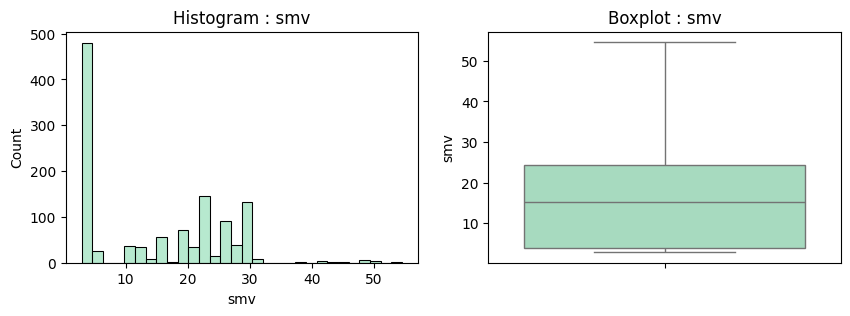

Shapiro Result: 1.5818186979900694e-31


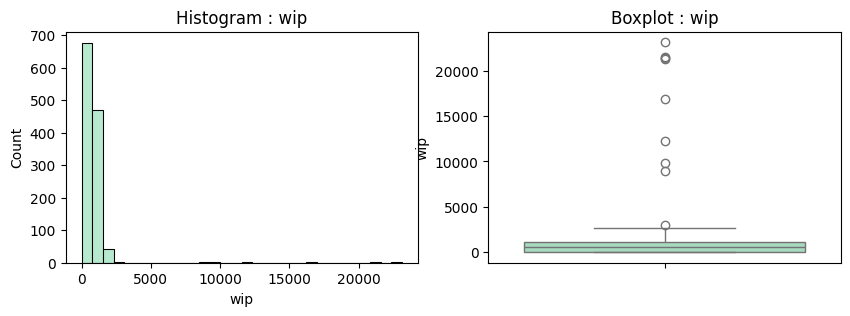

Shapiro Result: 2.866917956332116e-55


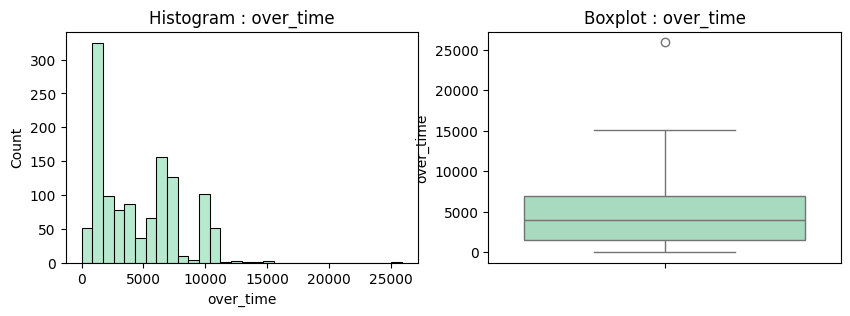

Shapiro Result: 9.320972695709268e-27


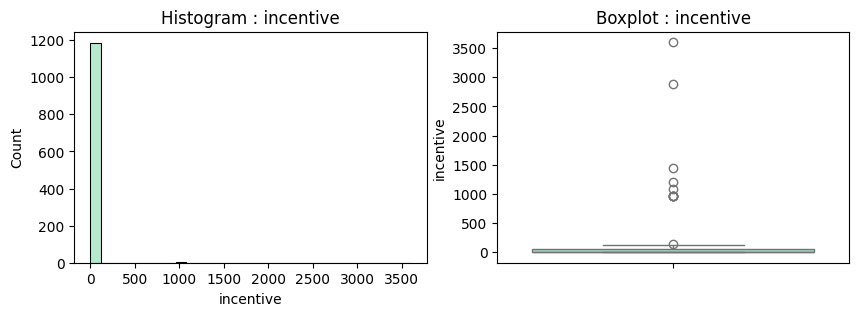

Shapiro Result: 1.6122624307524022e-58


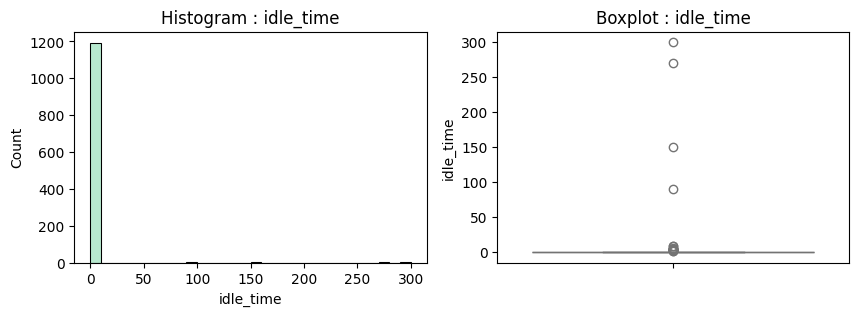

Shapiro Result: 8.131311232290709e-61


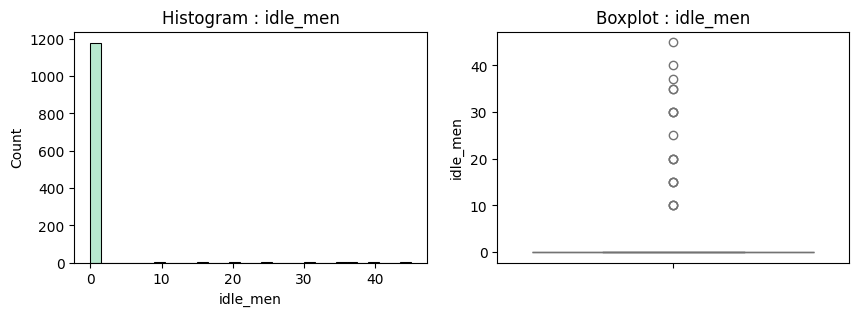

Shapiro Result: 1.0482499424867543e-59


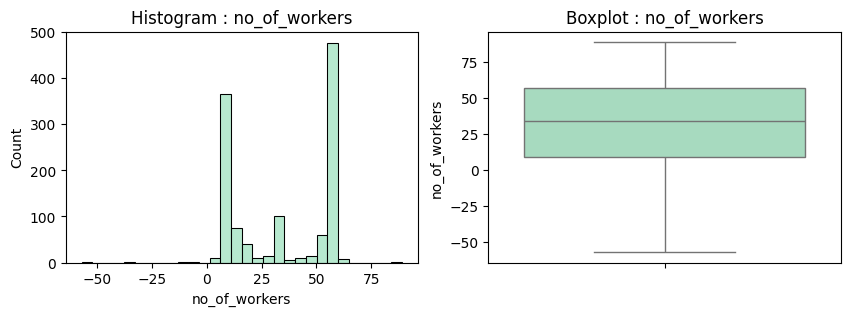

Shapiro Result: 1.456829279237741e-36


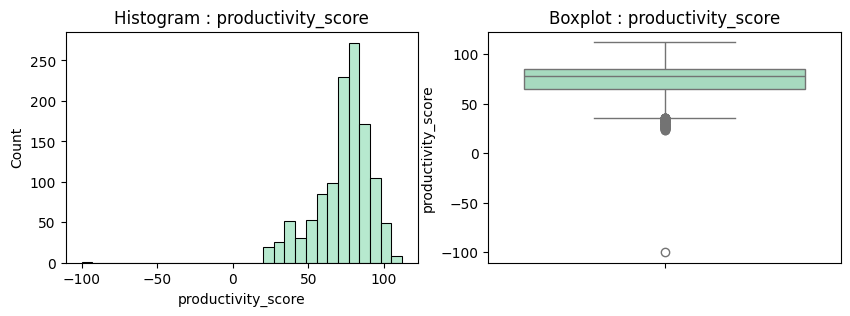

Shapiro Result: 2.3192235398999255e-25


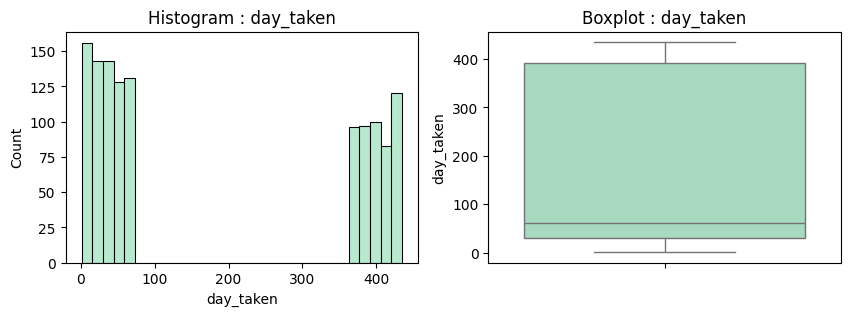

Shapiro Result: 1.8865212702538903e-40


In [25]:
def dist_check(data, columns):
  for c in columns:
    plt.figure(figsize = (10, 3))
    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(data[c],
                 bins = 30,
                 color = "#9FE2BF")
    plt.title(f"Histogram : {c}")
    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y = data[c],
                color = "#9FE2BF")
    plt.title(f"Boxplot : {c}")

    plt.show()
    _, p_value = shapiro(data[c])
    print(f"Shapiro Result: {p_value}")
dist_check(data, num)

> Key observations from the output:
> - Columns *incentive*, *idle_time*, and *idle_men* show extreme zero bias, these distributions are considered valid for real-world applications, so no action will be taken on these columns.  
> - *no_of_workers* and *productivity_score* contain negative values, these are impossible in real-world contexts, so I will remove records containing these anomalies.  
> - *productivity_score* contains values >100%, which is inconsistent with percentage representation, so I will filter out these outliers.  
> - *day_taken* shows two distinct clusters, suggests data was recorded during two separate time periods.  
> - All columns fail Shapiro-Wilk normality test (p-value <0.05), so *StandardScaler* is inappropriate, since it would introduce bias.

In [26]:
def remove_negative_values(data, column):
    for i in column:
        indices_to_drop = data[data[i] < 0].index
        data = data.drop(indices_to_drop)
        print(f"{i} with negative values dropped.")
    return data

data = remove_negative_values(data, ["no_of_workers", "productivity_score"])

no_of_workers with negative values dropped.
productivity_score with negative values dropped.


In [27]:
indices_to_drop = data[data["productivity_score"] > 100].index
data = data.drop(indices_to_drop)
print("productivity_score > 100 dropped.")

productivity_score > 100 dropped.


In [28]:
data[num].describe()

,smv,wip,over_time,incentive,idle_time,idle_men,no_of_workers,productivity_score,day_taken
count,1154.000000,1154.000000,1154.000000,1154.000000,1154.000000,1154.000000,1154.000000,1154.000000,1154.000000
mean,15.015927,665.347487,4582.556326,37.038128,0.757366,0.383016,34.340555,72.563082,190.742634
std,11.016275,1460.898517,3366.160939,162.707961,12.943789,3.328594,22.190527,16.966203,181.813345
min,2.900000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,23.371000,1.000000
25%,3.940000,0.000000,1440.000000,0.000000,0.000000,0.000000,9.000000,65.004000,29.000000
50%,15.260000,562.000000,3960.000000,0.000000,0.000000,0.000000,34.000000,75.442500,62.000000
75%,24.260000,1069.750000,6960.000000,50.000000,0.000000,0.000000,57.000000,84.405250,393.000000
max,54.560000,23122.000000,25920.000000,3600.000000,300.000000,45.000000,89.000000,100.000000,435.000000


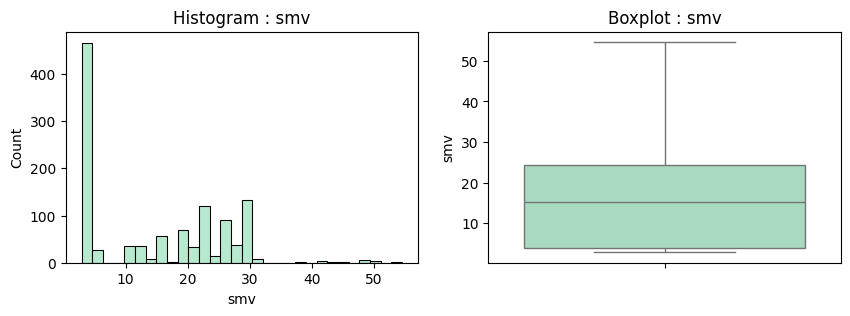

Shapiro Result: 4.143491798503371e-31


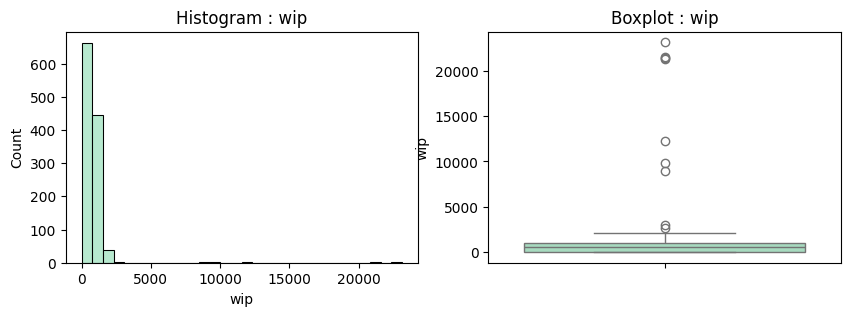

Shapiro Result: 1.4186972557105858e-54


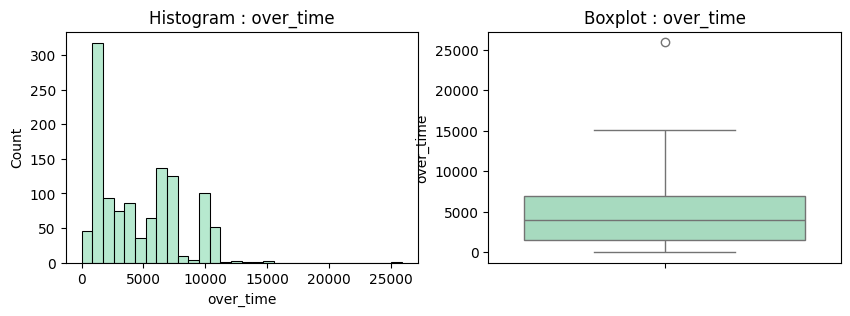

Shapiro Result: 1.8998742473315013e-26


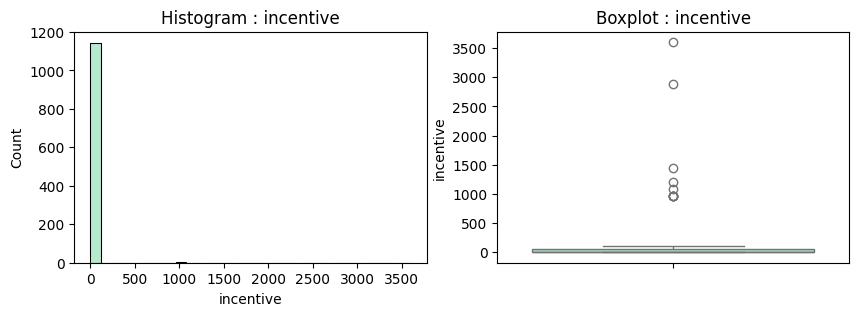

Shapiro Result: 5.902563854025692e-58


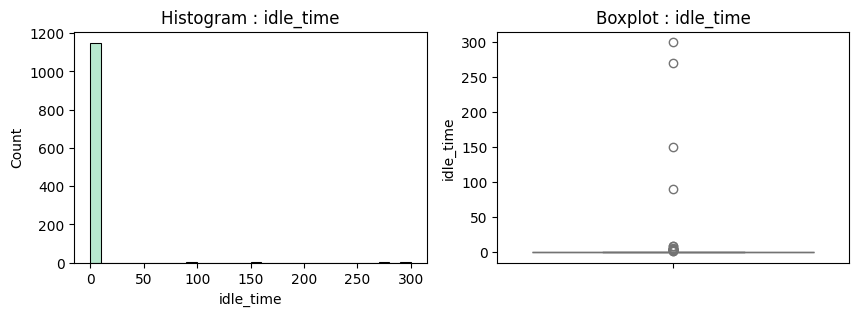

Shapiro Result: 4.89739449252661e-60


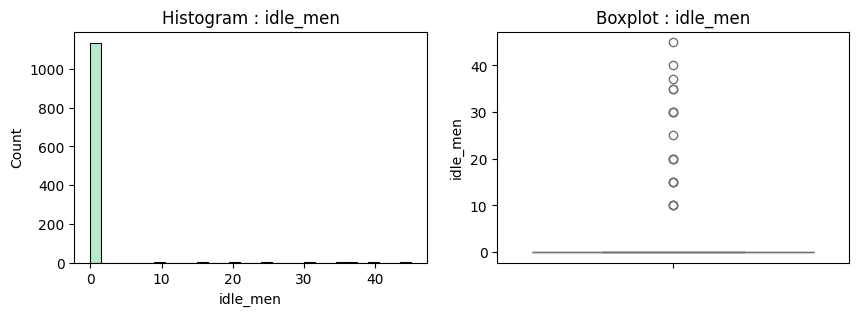

Shapiro Result: 6.651917691887184e-59


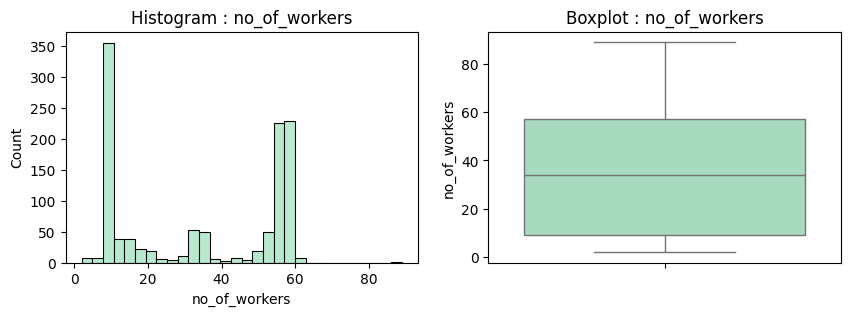

Shapiro Result: 1.2143202669196713e-36


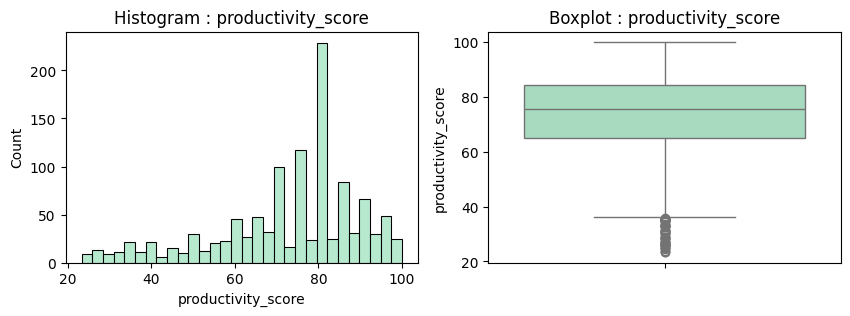

Shapiro Result: 6.316913486361487e-23


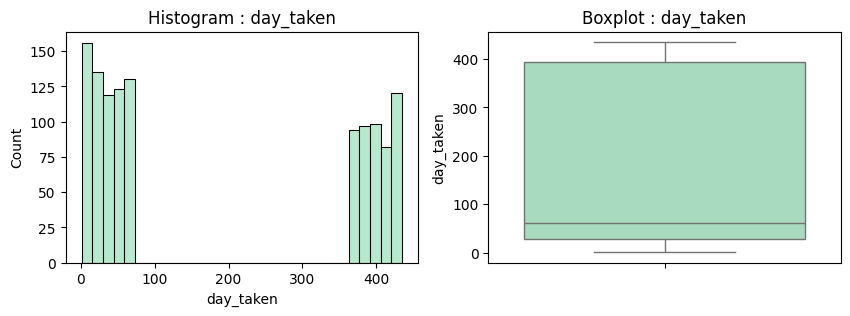

Shapiro Result: 1.0743820181114997e-39


In [29]:
dist_check(data, num)

> Here, I have dropped rows containing negative values in *no_of_workers* and *productivity_score*, as well as *productivity_score* values exceeding 100.

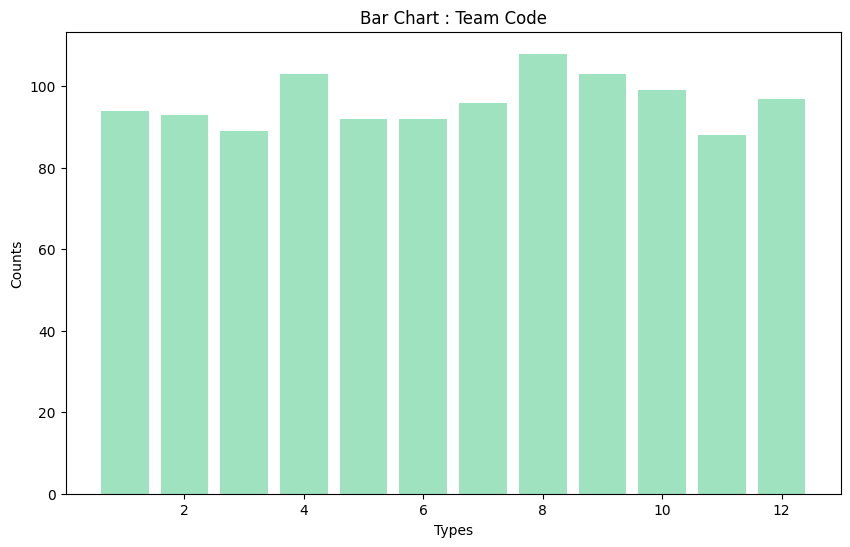

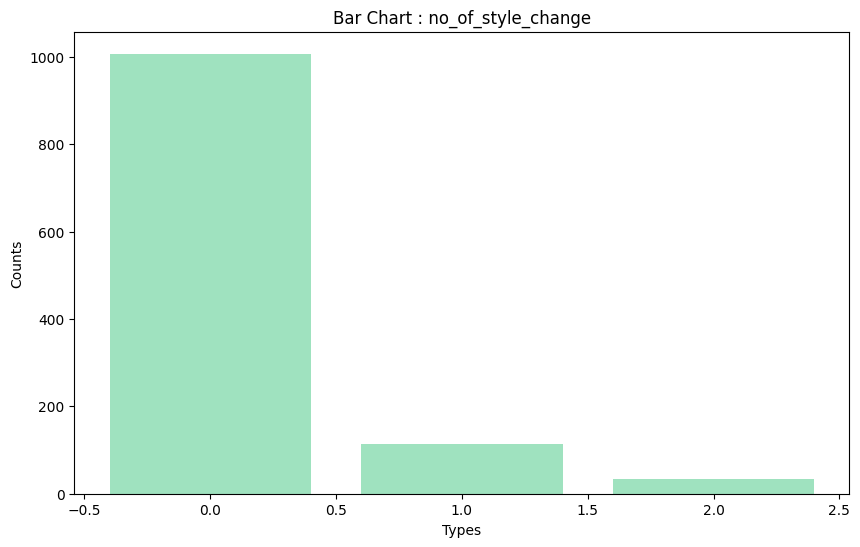

In [30]:
def categorical_dist(data, columns):
  for c in columns:
    plt.figure(figsize = (10, 6))

    plt.bar(x = data[c].value_counts().index,
            height = data[c].value_counts().values,
            color = "#9FE2BF")
    plt.title(f"Bar Chart : {c}")
    plt.xlabel("Types")
    plt.ylabel("Counts")

    plt.show()

categorical_dist(data, cat)

> Based on the plot above:  
> - The *Team Code* distribution is relatively even.  
> - *no_of_style_change* is heavily skewed toward 0, indicating no style changes occurred in most cases.

##### **CORRELATION**

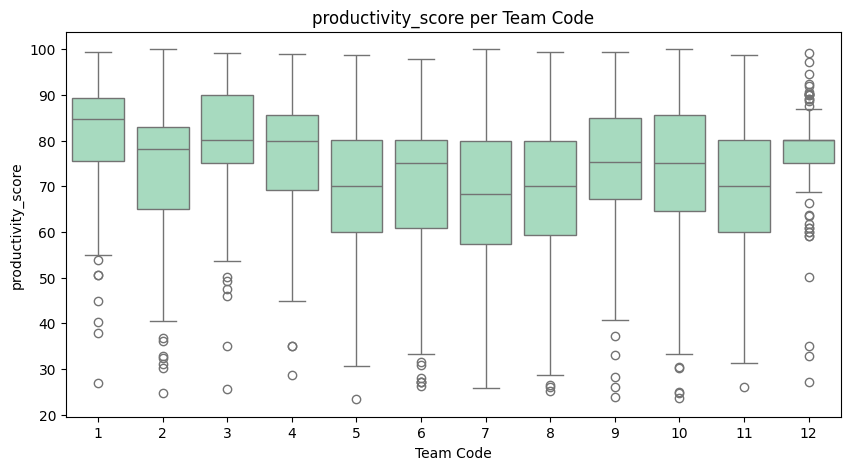

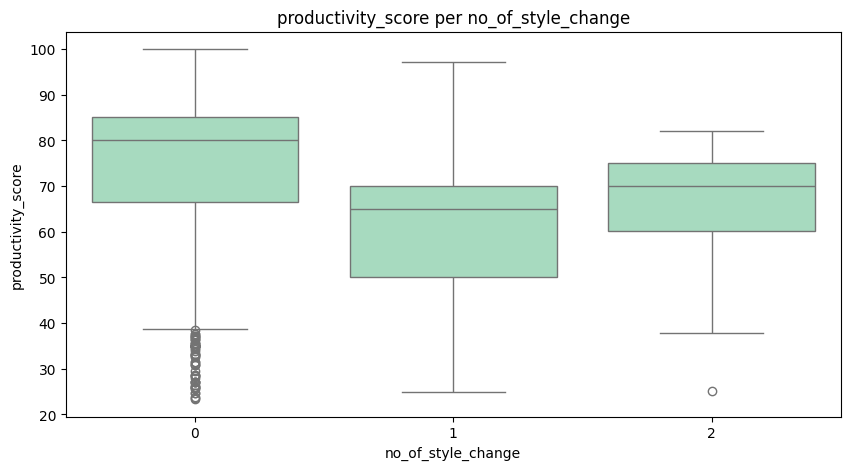

In [31]:
def categorical_correlation(data, columns, y):
  for c in columns:
    plt.figure(figsize = (10, 5))
    sns.boxplot(x = data[c],
                y = data[y],
                color = "#9FE2BF")
    plt.title(f"{y} per {c}")
    plt.show()

categorical_correlation(data, cat, "productivity_score")

> The plot above shows that *productivity_score* is not significantly influenced by categorical columns, as their values are distributed within the same range.

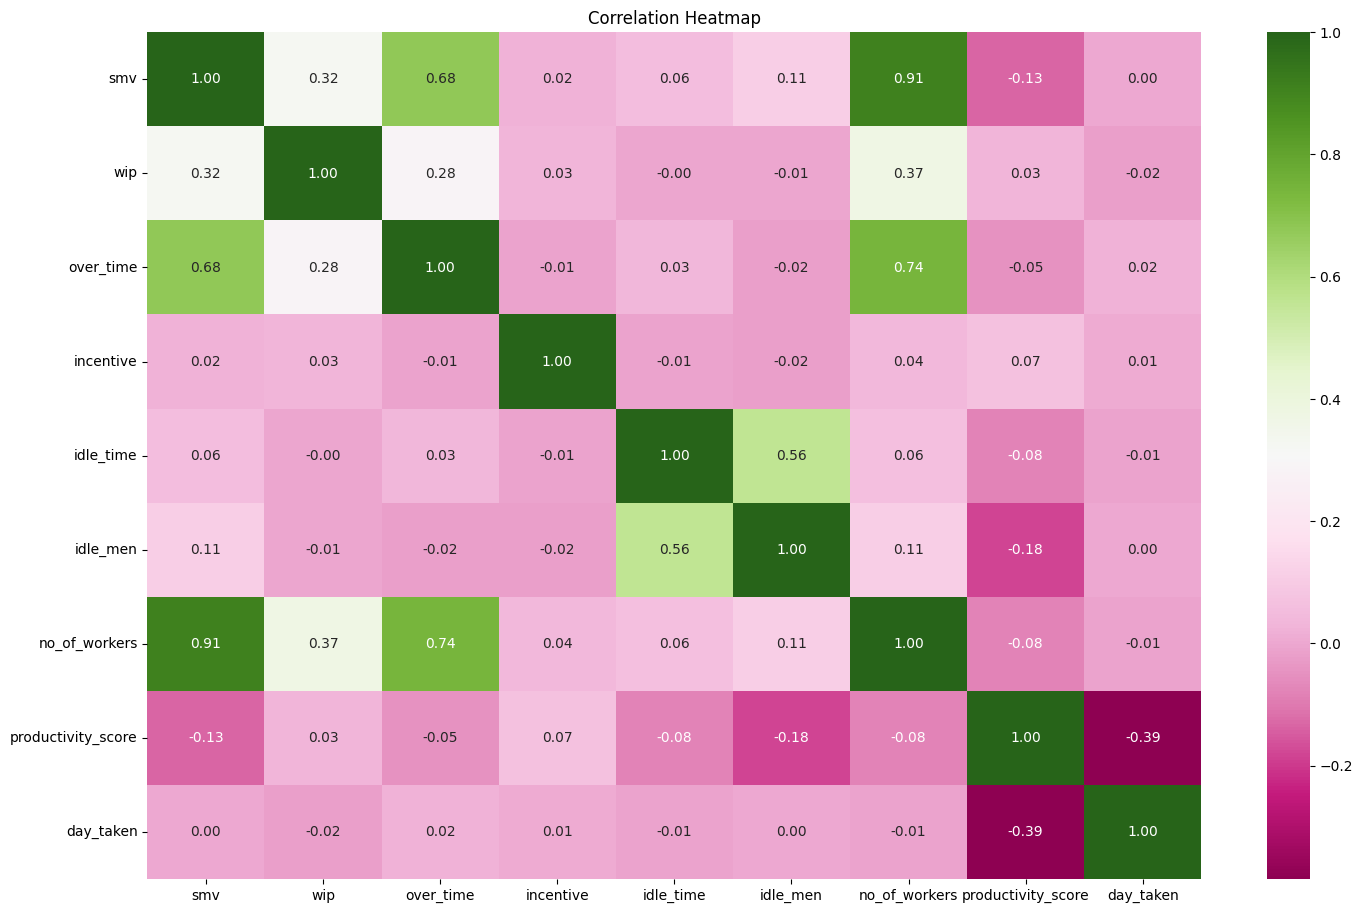

In [32]:
def heatmap(data):
  plt.figure(figsize = (17, 11))

  sns.heatmap(data.corr(),
              annot = True,
              cmap = "PiYG",
              fmt = ".2f",
              cbar = True)
  plt.title("Correlation Heatmap")
  plt.xlabel("")
  plt.ylabel("")

  plt.show()

heatmap(data[num])

> The heatmap reveals that *smv*, *over_time*, and *no_of_workers* exhibit multicollinearity due to their high inter-feature correlations.  
> The most influential feature for *productivity_score* is *day_taken* (-0.39 correlation) – the feature engineered during preprocessing.

##### **DATA SPLITTING**

In [33]:
x, y = data.drop(["productivity_score"], axis = 1), data["productivity_score"]
x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size = 0.2,
                                                    random_state = SEED)
x_train, x_val, y_train, y_val = train_test_split(x_train, 
                                                  y_train,
                                                  test_size = 0.1,
                                                  random_state = SEED)
print(f"Train: {x_train.shape}, {y_train.shape}")
print(f"Val: {x_val.shape}, {y_val.shape}")
print(f"Test: {x_test.shape}, {y_test.shape}")

Train: (830, 10), (830,)
Val: (93, 10), (93,)
Test: (231, 10), (231,)


##### **ENCODING**

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1154 entries, 0 to 1196
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Team Code           1154 non-null   int64  
 1   smv                 1154 non-null   float64
 2   wip                 1154 non-null   float64
 3   over_time           1154 non-null   int64  
 4   incentive           1154 non-null   int64  
 5   idle_time           1154 non-null   float64
 6   idle_men            1154 non-null   int64  
 7   no_of_style_change  1154 non-null   int64  
 8   no_of_workers       1154 non-null   float64
 9   productivity_score  1154 non-null   float64
 10  day_taken           1154 non-null   int64  
dtypes: float64(5), int64(6)
memory usage: 108.2 KB


> Since there are no non-numeric features in the dataset, no encoding process is required.

##### **SCALING**

In [35]:
x_train.describe()

,Team Code,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,day_taken
count,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000
mean,6.575904,15.180434,685.057831,4629.397590,41.785542,1.037952,0.436145,0.151807,34.549398,189.930120
std,3.412303,11.032962,1609.008620,3413.426489,190.851485,15.253430,3.505315,0.423769,22.216380,181.523202
min,1.000000,2.900000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000
25%,4.000000,3.940000,0.000000,1440.000000,0.000000,0.000000,0.000000,0.000000,9.000000,31.000000
50%,7.000000,15.260000,603.500000,4080.000000,0.000000,0.000000,0.000000,0.000000,34.000000,62.000000
75%,9.000000,25.752500,1069.000000,6960.000000,50.000000,0.000000,0.000000,0.000000,57.000000,392.000000
max,12.000000,54.560000,23122.000000,25920.000000,3600.000000,300.000000,45.000000,2.000000,89.000000,435.000000


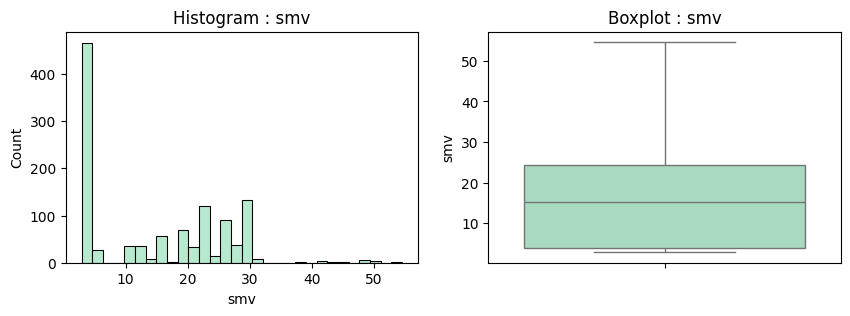

Shapiro Result: 4.143491798503371e-31


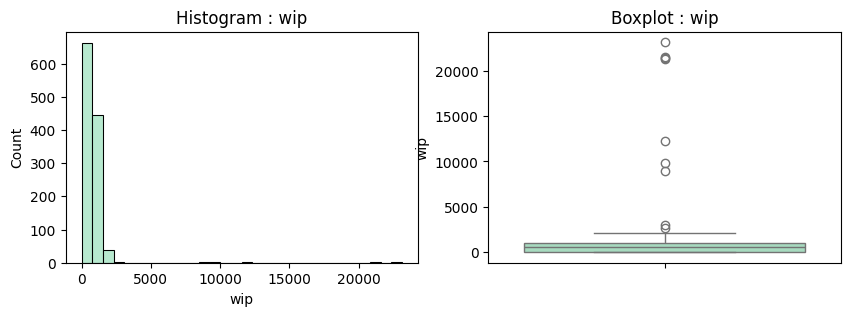

Shapiro Result: 1.4186972557105858e-54


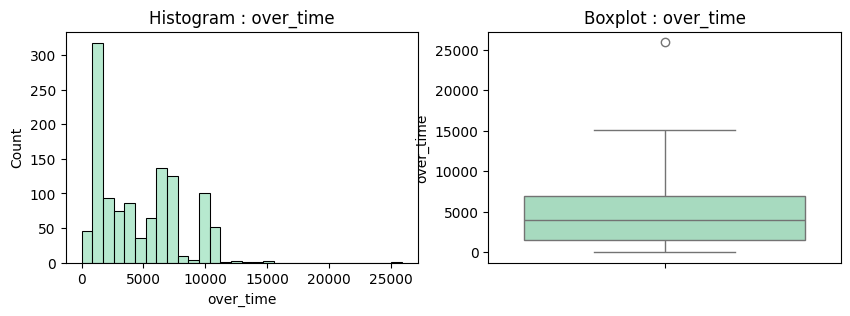

Shapiro Result: 1.8998742473315013e-26


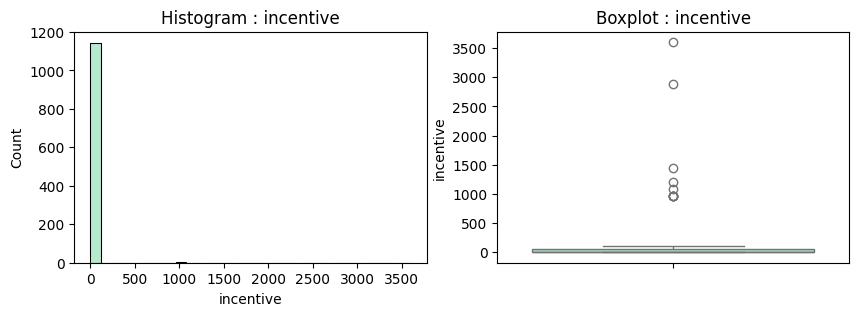

Shapiro Result: 5.902563854025692e-58


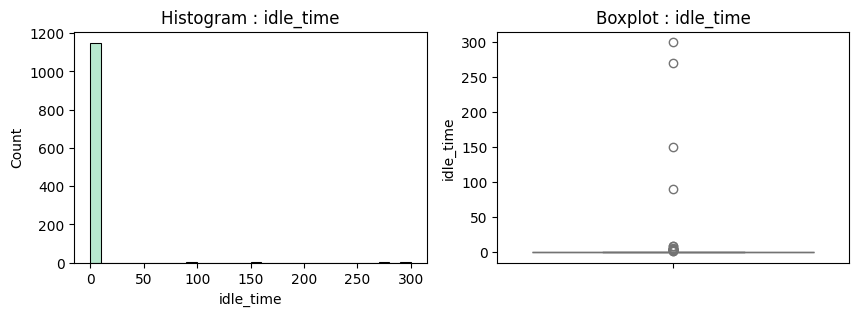

Shapiro Result: 4.89739449252661e-60


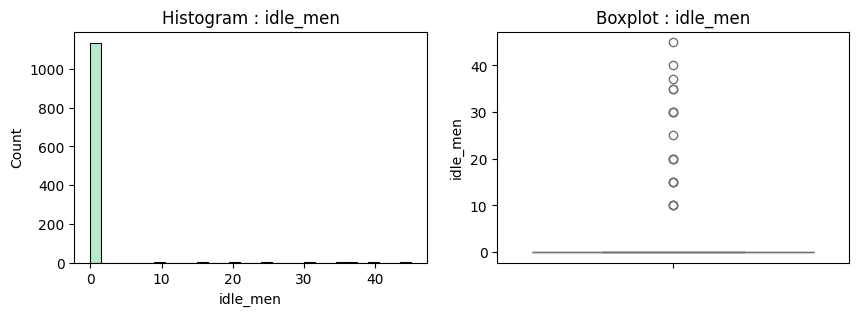

Shapiro Result: 6.651917691887184e-59


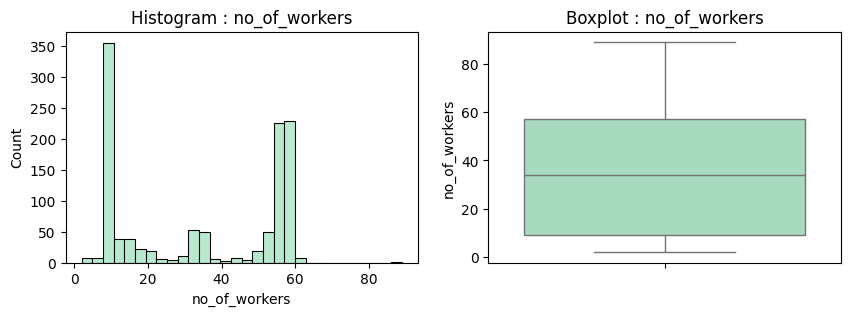

Shapiro Result: 1.2143202669196713e-36


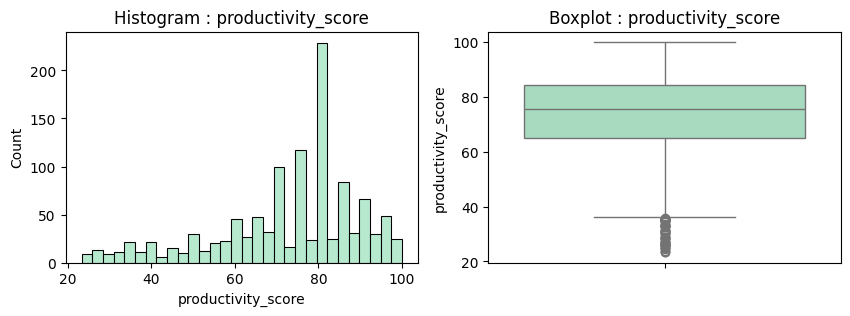

Shapiro Result: 6.316913486361487e-23


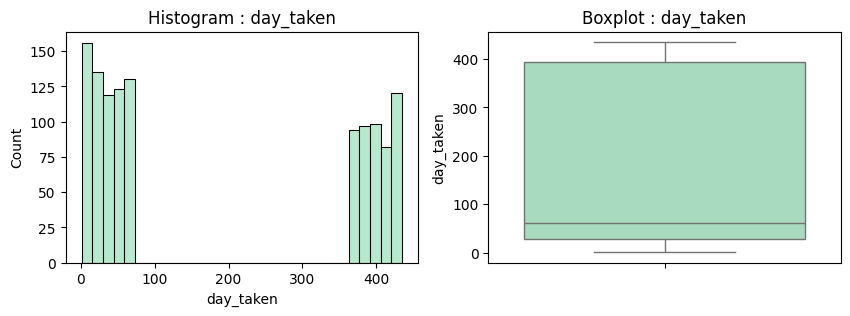

Shapiro Result: 1.0743820181114997e-39


In [36]:
dist_check(data, num)

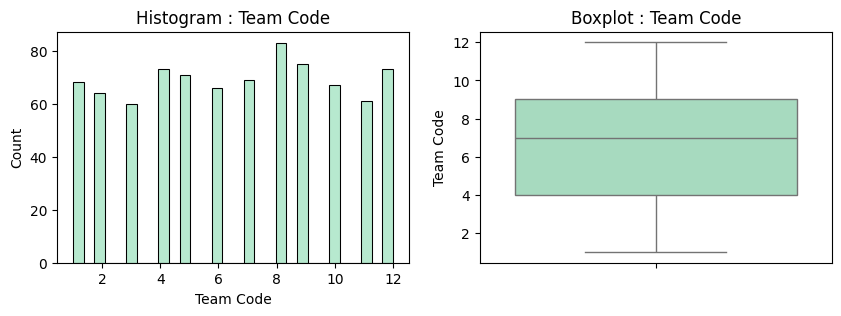

Shapiro Result: 4.876570120901532e-17


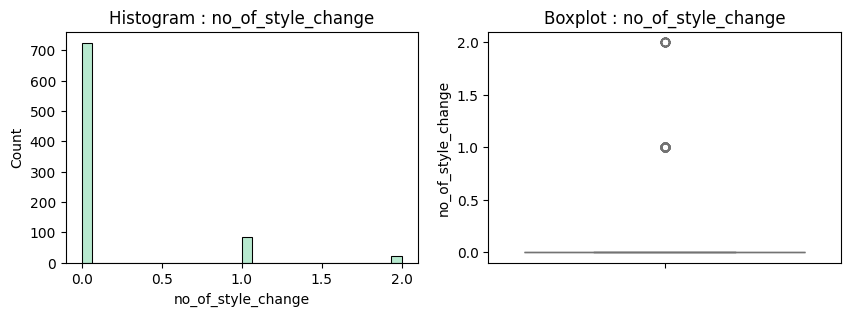

Shapiro Result: 5.601717372705484e-46


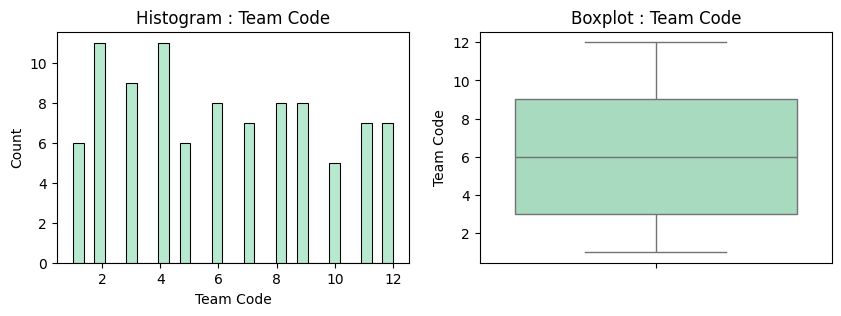

Shapiro Result: 0.00022679913401849828


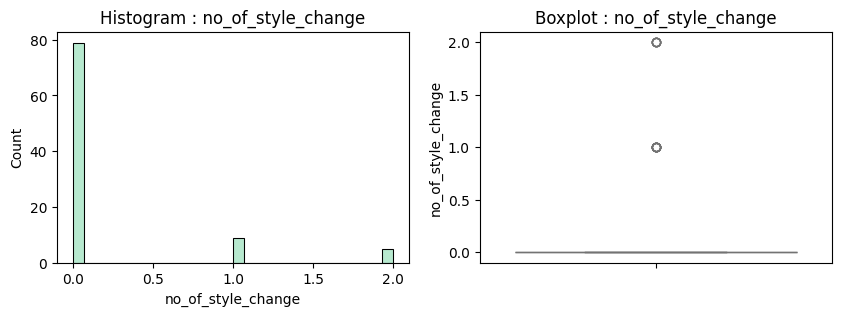

Shapiro Result: 3.3436327437558543e-17


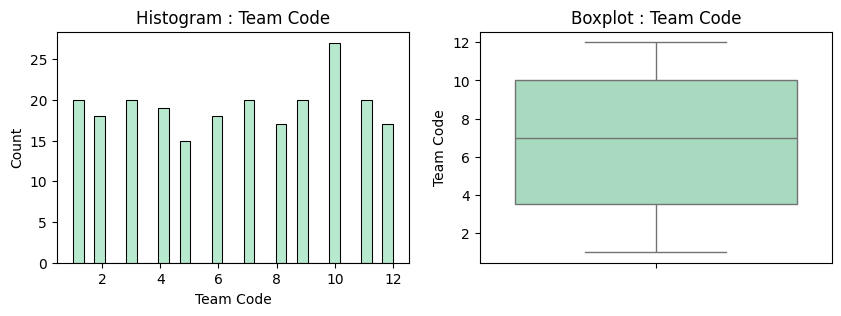

Shapiro Result: 1.3051245110813462e-08


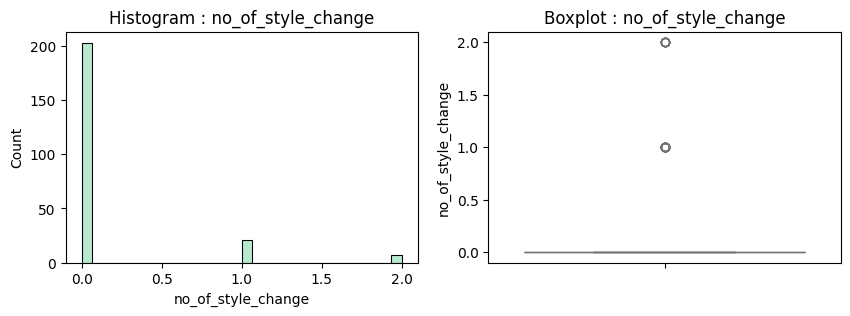

Shapiro Result: 2.595192985573283e-27


In [37]:
dist_check(x_train, cat)
dist_check(x_val, cat)
dist_check(x_test, cat)

> As noted in the [**DISTRIBUTION**](#DISTRIBUTION) section, [*StandardScaler*](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) is unsuitable due to non-normal data distributions.  
> Since the features *wip*, *over_time*, *incentive*, *idle_time*, and *idle_men* contain extreme outliers, I will implement [*RobustScaler*](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html) for its outlier resistance.  
> I also applied *RobustScaler* uniformly across all columns to prevent bias from mixed scaling ranges and ensure consistent value ranges for modeling.

In [38]:
scaler_x = RobustScaler()
x_train = pd.DataFrame(scaler_x.fit_transform(x_train), columns = x_train.columns, index = x_train.index)
x_val = pd.DataFrame(scaler_x.transform(x_val), columns = x_val.columns, index = x_val.index)
x_test = pd.DataFrame(scaler_x.transform(x_test), columns = x_test.columns, index = x_test.index)
print("RobustScaler performed.")

RobustScaler performed.


In [39]:
scaler_y = RobustScaler()
y_train = scaler_y.fit_transform(pd.DataFrame(y_train))
y_val = scaler_y.transform(pd.DataFrame(y_val))
y_test = scaler_y.transform(pd.DataFrame(y_test))
print("RobustScaler performed.")

RobustScaler performed.


In [40]:
x_train.describe()

,Team Code,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,day_taken
count,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000
mean,-0.084819,-0.003648,0.076294,0.099529,0.835711,1.037952,0.436145,0.151807,0.011446,0.354377
std,0.682461,0.505809,1.505153,0.618374,3.817030,15.253430,3.505315,0.423769,0.462841,0.502834
min,-1.200000,-0.566648,-0.564546,-0.739130,0.000000,0.000000,0.000000,0.000000,-0.666667,-0.168975
25%,-0.600000,-0.518968,-0.564546,-0.478261,0.000000,0.000000,0.000000,0.000000,-0.520833,-0.085873
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.400000,0.481032,0.435454,0.521739,1.000000,0.000000,0.000000,0.000000,0.479167,0.914127
max,1.000000,1.801719,21.065014,3.956522,72.000000,300.000000,45.000000,2.000000,1.145833,1.033241


In [41]:
x_val.describe()

,Team Code,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,day_taken
count,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000
mean,-0.167742,0.034507,0.190657,0.107994,0.570968,0.064516,0.537634,0.204301,0.080645,0.376642
std,0.682890,0.493183,1.473821,0.565782,0.599046,0.461718,4.264513,0.522518,0.448537,0.516379
min,-1.200000,-0.566648,-0.564546,-0.739130,0.000000,0.000000,0.000000,0.000000,-0.541667,-0.168975
25%,-0.800000,-0.509341,-0.564546,-0.413043,0.000000,0.000000,0.000000,0.000000,-0.458333,-0.102493
50%,-0.200000,0.000000,0.005145,-0.076087,0.460000,0.000000,0.000000,0.000000,0.375000,-0.008310
75%,0.400000,0.499713,0.439196,0.521739,1.000000,0.000000,0.000000,0.000000,0.500000,0.925208
max,1.000000,1.551404,10.905051,1.184783,2.000000,4.000000,40.000000,2.000000,0.531250,1.033241


In [42]:
x_test.describe()

,Team Code,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,day_taken
count,231.000000,231.000000,231.000000,231.000000,231.000000,231.000000,231.000000,231.000000,231.000000,231.000000
mean,-0.079654,-0.056685,-0.061859,0.053728,0.467965,0.028139,0.129870,0.151515,-0.038149,0.356657
std,0.696246,0.506071,0.552420,0.596765,0.555956,0.427669,1.973855,0.435875,0.463130,0.503383
min,-1.200000,-0.566648,-0.564546,-0.739130,0.000000,0.000000,0.000000,0.000000,-0.666667,-0.168975
25%,-0.700000,-0.518968,-0.564546,-0.478261,0.000000,0.000000,0.000000,0.000000,-0.541667,-0.092798
50%,0.000000,-0.176504,-0.208138,-0.108696,0.000000,0.000000,0.000000,0.000000,-0.052083,0.005540
75%,0.600000,0.342693,0.434986,0.500000,0.910000,0.000000,0.000000,0.000000,0.468750,0.918283
max,1.000000,1.614670,2.226848,1.543478,1.800000,6.500000,30.000000,2.000000,0.541667,1.033241


In [43]:
pd.DataFrame(y_train).describe()

,0
count,8.300000e+02
mean,-1.655356e-01
std,8.998531e-01
min,-2.750033e+00
25%,-5.633155e-01
50%,3.745919e-16
75%,4.366845e-01
max,1.289770e+00


In [44]:
pd.DataFrame(y_val).describe()

,0
count,93.000000
mean,-0.077630
std,0.855118
min,-2.621979
25%,-0.391649
50%,0.235548
75%,0.501621
max,1.229881


In [45]:
pd.DataFrame(y_test).describe()

,0
count,231.000000
mean,-0.156669
std,0.892574
min,-2.614703
25%,-0.509661
50%,-0.025305
75%,0.476026
max,1.289770


> All features have now been scaled to prevent model bias.

#### **MODELLING**

In [46]:
def r_squared(y_true, y_pred):
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    r2 = 1 - ss_res / (ss_tot + tf.keras.backend.epsilon())
    return r2

##### **SEQUENTIAL MODELLING AND TRAINING**

In [47]:
model_s = Sequential([
    Dense(44, 
          activation = "relu", 
          input_shape = (10, )), 
    Dense(44, 
          activation = "relu"),
    Dense(44, 
          activation = "relu"),
    Dense(44, 
          activation = "relu"),
    Dense(1)
])
print("Sequential model created.")
model_s.summary()

Sequential model created.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 44)                484       
                                                                 
 dense_1 (Dense)             (None, 44)                1980      
                                                                 
 dense_2 (Dense)             (None, 44)                1980      
                                                                 
 dense_3 (Dense)             (None, 44)                1980      
                                                                 
 dense_4 (Dense)             (None, 1)                 45        
                                                                 
Total params: 6,469
Trainable params: 6,469
Non-trainable params: 0
_________________________________________________________________


In [48]:
model_s.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 3e-5),
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = [tf.keras.metrics.MeanAbsoluteError(),
              tf.keras.metrics.RootMeanSquaredError(),
              r_squared]
)
print("Sequential model compiled.")

Sequential model compiled.


In [49]:
history_s = model_s.fit(
    x_train, y_train,
    validation_data = (x_val, y_val),
    epochs = 50,
    batch_size = 32,
    verbose = 1
)

Epoch 1/50
26/26 [==============================] - 5s 33ms/step - loss: 3.9755 - mean_absolute_error: 0.8334 - root_mean_squared_error: 1.9939 - r_squared: -3.5657 - val_loss: 0.7993 - val_mean_absolute_error: 0.6947 - val_root_mean_squared_error: 0.8940 - val_r_squared: -0.1618
Epoch 2/50
26/26 [==============================] - 0s 14ms/step - loss: 3.6746 - mean_absolute_error: 0.8198 - root_mean_squared_error: 1.9169 - r_squared: -4.3198 - val_loss: 0.7755 - val_mean_absolute_error: 0.6851 - val_root_mean_squared_error: 0.8806 - val_r_squared: -0.1276
Epoch 3/50
26/26 [==============================] - 0s 15ms/step - loss: 3.3954 - mean_absolute_error: 0.8059 - root_mean_squared_error: 1.8427 - r_squared: -2.4960 - val_loss: 0.7568 - val_mean_absolute_error: 0.6770 - val_root_mean_squared_error: 0.8700 - val_r_squared: -0.1009
Epoch 4/50
26/26 [==============================] - 0s 13ms/step - loss: 3.1574 - mean_absolute_error: 0.7956 - root_mean_squared_error: 1.7769 - r_squared: 

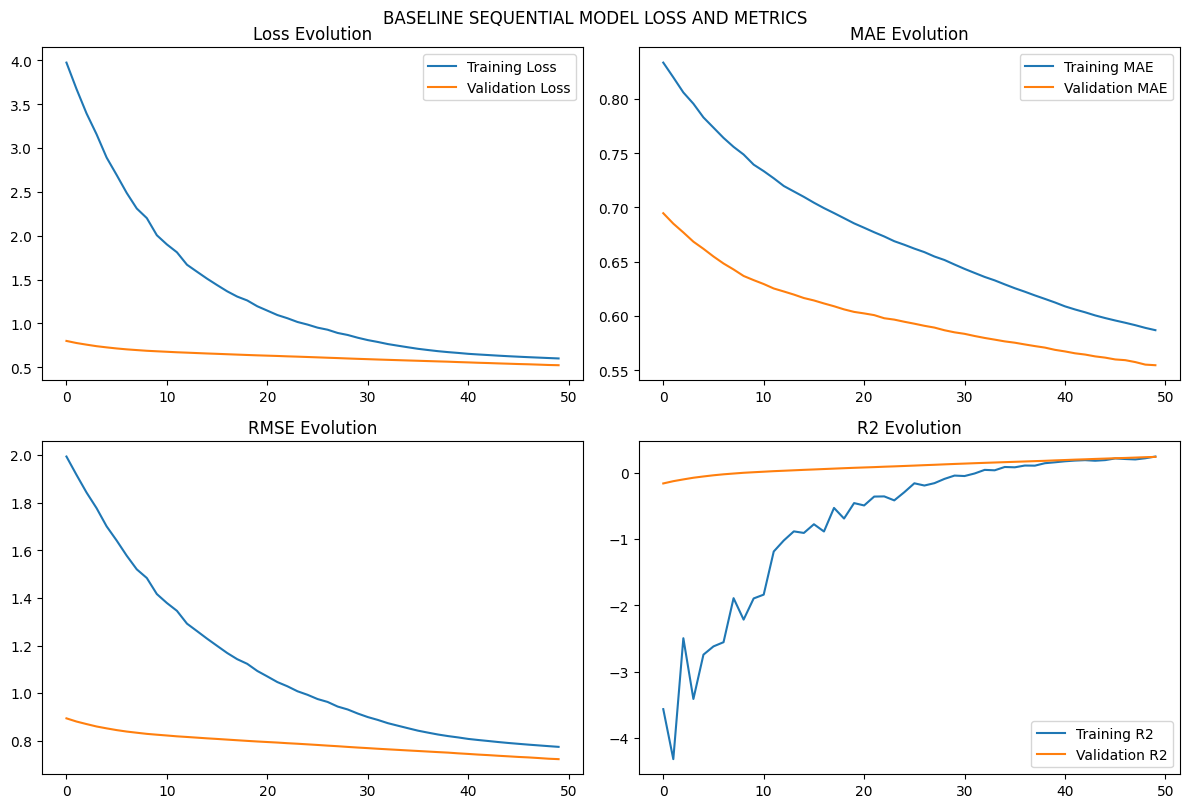

In [50]:
plt.figure(figsize = (12, 16))
plt.suptitle("BASELINE SEQUENTIAL MODEL LOSS AND METRICS")

plt.subplot(4, 2, 1)
plt.plot(history_s.history["loss"], 
         label = "Training Loss")
plt.plot(history_s.history["val_loss"], 
         label = "Validation Loss")
plt.title("Loss Evolution")
plt.legend()

plt.subplot(4, 2, 2)
plt.plot(history_s.history["mean_absolute_error"], 
         label = "Training MAE")
plt.plot(history_s.history["val_mean_absolute_error"], 
         label = "Validation MAE")
plt.title("MAE Evolution")
plt.legend()

plt.subplot(4, 2, 3)
plt.plot(history_s.history["root_mean_squared_error"], 
         label = "Training RMSE")
plt.plot(history_s.history["val_root_mean_squared_error"], 
         label = "Validation RMSE")
plt.title("RMSE Evolution")

plt.subplot(4, 2, 4)
plt.plot(history_s.history["r_squared"], 
         label = "Training R2")
plt.plot(history_s.history["val_r_squared"], 
         label = "Validation R2")
plt.title("R2 Evolution")

plt.legend()
plt.tight_layout()
plt.show()

> The Loss Evolution, MAE Evolution, RMSE Evolution, and R2 Evolution plots indicate that my baseline sequential model is not overfitting, as the gap between training and validation loss remains below 0.08.  
> However, the model's overall performance remains suboptimal, with an MSE loss of approximately 0.60 and RMSE of about 0.77. This suggests the model's average error covers roughly 19% of the target data's range, since the [scaled *productivity_score*](#SCALING) ranges from -2.7 to 1.2 (spanning ~3.9 units).  
> Additionally, both training and validation R² scores only reach around 24%, which is poor performance as it means the model explains just 24% of the target data variance.  
> As an initial hypothesis, these issues may stem from: poor-quality data with low feature correlations ([**CORRELATION**](#CORRELATION)), suboptimal activation function choices, or insufficient model complexity.
> To test these hypotheses, I will experiment with adjusting layers and neurons in the [next section](#Part-C).

##### **FUNCTIONAL MODELLING AND TRAINING**

> In this section, I developed a baseline functional model with modified layer architecture and neuron counts per layer compared to the [baseline sequential model](#SEQUENTIAL-MODELLING-AND-TRAINING).

In [51]:
inputs = tf.keras.Input(shape = (10, ))
dense_1 = Dense(70, 
                activation = "relu")(inputs)
dense_2 = Dense(70, 
                activation = "relu")(dense_1)
dense_3 = Dense(70, 
                activation = "relu")(dense_2)
dense_4 = Dense(70, 
                activation = "relu")(dense_3)
outputs = Dense(1)(dense_4)

model_f = Model(inputs = inputs,
                outputs = outputs)
print("Functional model created.")
model_f.summary()

Functional model created.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense_5 (Dense)             (None, 70)                770       
                                                                 
 dense_6 (Dense)             (None, 70)                4970      
                                                                 
 dense_7 (Dense)             (None, 70)                4970      
                                                                 
 dense_8 (Dense)             (None, 70)                4970      
                                                                 
 dense_9 (Dense)             (None, 1)                 71        
                                                                 
Total params: 15,751
Trainable para

In [52]:
model_f.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 3e-5),
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = [tf.keras.metrics.MeanAbsoluteError(),
               tf.keras.metrics.RootMeanSquaredError(),
               r_squared]
)
print("Functional model compiled.")

Functional model compiled.


In [53]:
history_f = model_f.fit(
    x_train, y_train,
    validation_data = (x_val, y_val),
    epochs = 50,
    batch_size = 32,
    verbose = 1
)

Epoch 1/50
26/26 [==============================] - 2s 31ms/step - loss: 1.6105 - mean_absolute_error: 0.7425 - root_mean_squared_error: 1.2691 - r_squared: -0.8979 - val_loss: 0.8301 - val_mean_absolute_error: 0.6505 - val_root_mean_squared_error: 0.9111 - val_r_squared: -0.2099
Epoch 2/50
26/26 [==============================] - 0s 14ms/step - loss: 1.3120 - mean_absolute_error: 0.7241 - root_mean_squared_error: 1.1454 - r_squared: -0.7397 - val_loss: 0.7888 - val_mean_absolute_error: 0.6460 - val_root_mean_squared_error: 0.8881 - val_r_squared: -0.1496
Epoch 3/50
26/26 [==============================] - 0s 14ms/step - loss: 1.0946 - mean_absolute_error: 0.7054 - root_mean_squared_error: 1.0462 - r_squared: -0.3083 - val_loss: 0.7587 - val_mean_absolute_error: 0.6432 - val_root_mean_squared_error: 0.8710 - val_r_squared: -0.1059
Epoch 4/50
26/26 [==============================] - 0s 14ms/step - loss: 0.9603 - mean_absolute_error: 0.6925 - root_mean_squared_error: 0.9800 - r_squared: 

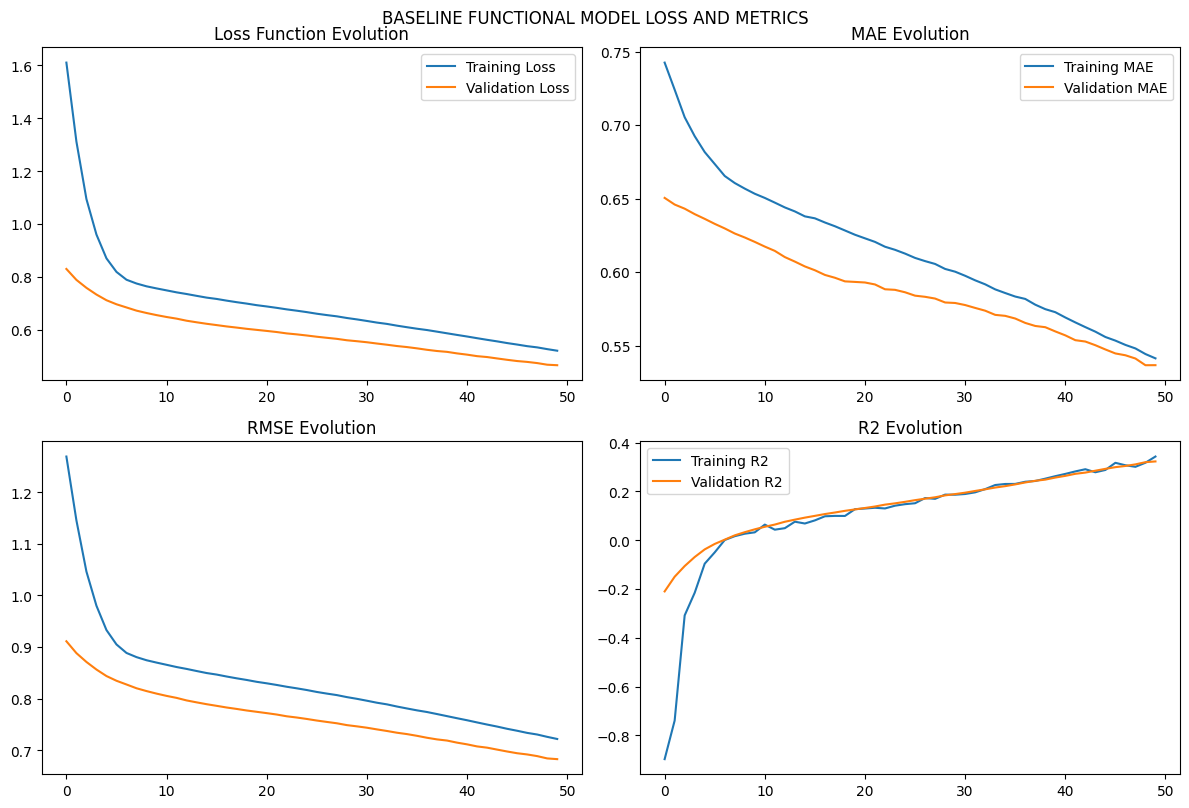

In [54]:
plt.figure(figsize = (12, 16))
plt.suptitle("BASELINE FUNCTIONAL MODEL LOSS AND METRICS")

plt.subplot(4, 2, 1)
plt.plot(history_f.history["loss"], 
         label = "Training Loss")
plt.plot(history_f.history["val_loss"], 
         label = "Validation Loss")
plt.title("Loss Function Evolution")
plt.legend()

plt.subplot(4, 2, 2)
plt.plot(history_f.history["mean_absolute_error"], 
         label = "Training MAE")
plt.plot(history_f.history["val_mean_absolute_error"], 
         label = "Validation MAE")
plt.title("MAE Evolution")
plt.legend()

plt.subplot(4, 2, 3)
plt.plot(history_f.history["root_mean_squared_error"], 
         label = "Training MAPE")
plt.plot(history_f.history["val_root_mean_squared_error"], 
         label = "Validation MAPE")
plt.title("RMSE Evolution")

plt.subplot(4, 2, 4)
plt.plot(history_f.history["r_squared"], 
         label = "Training R2")
plt.plot(history_f.history["val_r_squared"], 
         label = "Validation R2")
plt.title("R2 Evolution")

plt.legend()
plt.tight_layout()
plt.show()

> The Loss Evolution, MAE Evolution, RMSE Evolution, and R2 Evolution Plot demonstrate that my baseline functional model also shows no signs of overfitting, with a minimal gap (0.06) between training and validation loss.  
> Notably, this model achieves lower loss metrics than the [baseline sequential model](#SEQUENTIAL-MODELLING-AND-TRAINING) (MSE: ~0.52, RMSE: ~0.72). This translates to an average error covering ~18% of the target (*productivity_score*) range.  
> While the baseline functional model shows slight improvement in R2 (0.34), this remains unsatisfactory performance.  
> Consistent with my hypothesis in the [baseline sequential model](#SEQUENTIAL-MODELLING-AND-TRAINING) section, I will proceed to adjust layer architecture, neuron counts, and other hyperparameters in the [next section](#Part-C).

#### **MODEL MODIFICATION**

In [55]:
callback = [
    ModelCheckpoint(
        filepath = "best_model.h5",
        save_best_only = True,
        monitor = "val_r_squared",
        mode = "max"
    ),
    EarlyStopping(
        monitor = "val_loss",
        patience = 20,
        restore_best_weights = True,
        mode = "min"
    ),
    ReduceLROnPlateau(
        monitor = "val_loss",
        mode = "min",
        factor = 0.5, 
        patience = 5,
        min_lr = 1e-6
    )
]

> In the code above, I've prepared callbacks to be used as parameters in the modified model. The specific callbacks implemented are:  
> - *ModelCheckpoint*: saves the best model during training (prioritizing highest val_r_squared).  
> - *EarlyStopping*: halts training prematurely to prevent overfitting.  
> - *ReduceLROnPlateau*: automatically reduces the learning rate if val_loss fails to improve for 5 epochs.
>
> These callbacks collectively serve two primary purposes, overfitting prevention and optimization of val_loss and R² performance.

##### **SEQUENTIAL MODEL MODIFIED**

In [56]:
model_s_m = Sequential([
    Dense(32,  
          input_shape = (10, ),
          kernel_regularizer = l1(0.01)),
    BatchNormalization(),
    LeakyReLU(alpha = 0.001),
    Dropout(0.2),
    
    Dense(32,
          kernel_regularizer = l1(0.01)),
    BatchNormalization(),
    LeakyReLU(alpha = 0.001),
    Dropout(0.2),
    
    Dense(1)
])
print("Modified sequential model created.")
model_s_m.summary()

Modified sequential model created.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 32)                352       
                                                                 
 batch_normalization (BatchN  (None, 32)               128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32)                0         
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_11 (Dense)            (None, 32)                1056      
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)   

> For this modified sequential model, I made several architectural changes:
> - Adjusted the number of layers and neurons per layer.  
> - Switched to [*LeakyReLU*](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LeakyReLU) activation functions to test my initial hypothesis about the model's poor R² performance.  
> 
> I also implemented three key regularization techniques:
> - [*L1 Regularizer*](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/L1) to prevent overfitting by applying weight penalties.  
> - [*BatchNormalization*](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization) to normalize layer inputs using each batch's mean and variance.  
> - [*Dropout*](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) layers that randomly disable neurons during training to reduce overfitting.
> 
> This combination of modifications aims to improve model generalization while testing potential causes for the originally low R² scores.

In [57]:
model_s_m.compile(
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = [tf.keras.metrics.MeanAbsoluteError(),
              tf.keras.metrics.RootMeanSquaredError(),
              r_squared]
)
print("Sequential model compiled.")

Sequential model compiled.


In [58]:
history_s_m = model_s_m.fit(
    x_train, y_train,
    validation_data = (x_val, y_val),
    epochs = 500,
    batch_size = 32,
    verbose = 1,
    callbacks = callback
)

Epoch 1/500
26/26 [==============================] - 4s 46ms/step - loss: 3.1921 - mean_absolute_error: 0.7619 - root_mean_squared_error: 1.0056 - r_squared: -0.2910 - val_loss: 2.8806 - val_mean_absolute_error: 0.6619 - val_root_mean_squared_error: 0.8596 - val_r_squared: -0.0765 - lr: 0.0010
Epoch 2/500
26/26 [==============================] - 1s 26ms/step - loss: 3.0810 - mean_absolute_error: 0.7443 - root_mean_squared_error: 0.9844 - r_squared: -0.2593 - val_loss: 2.7672 - val_mean_absolute_error: 0.6376 - val_root_mean_squared_error: 0.8284 - val_r_squared: 5.3489e-04 - lr: 0.0010
Epoch 3/500
26/26 [==============================] - 1s 24ms/step - loss: 2.9086 - mean_absolute_error: 0.7003 - root_mean_squared_error: 0.9263 - r_squared: -0.1548 - val_loss: 2.6953 - val_mean_absolute_error: 0.6186 - val_root_mean_squared_error: 0.8241 - val_r_squared: 0.0097 - lr: 0.0010
Epoch 4/500
26/26 [==============================] - 1s 23ms/step - loss: 2.8506 - mean_absolute_error: 0.6966 - 

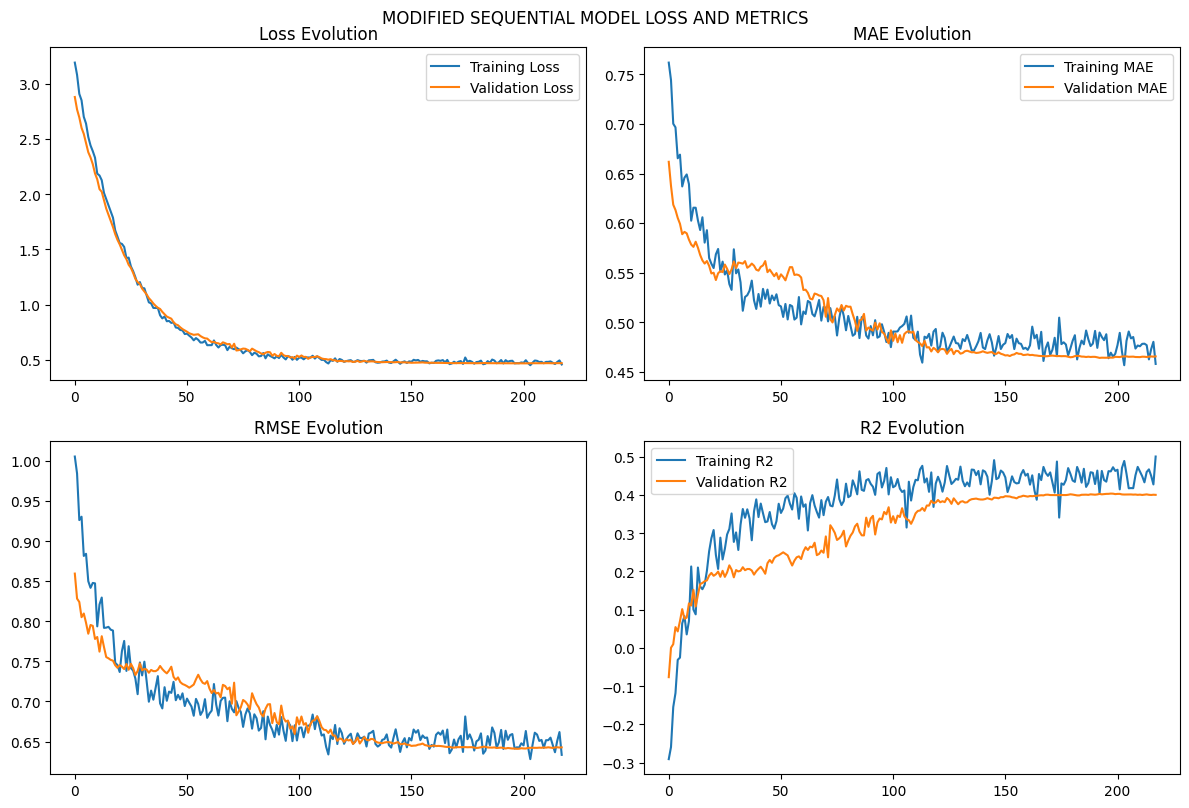

In [59]:
plt.figure(figsize = (12, 16))
plt.suptitle("MODIFIED SEQUENTIAL MODEL LOSS AND METRICS")

plt.subplot(4, 2, 1)
plt.plot(history_s_m.history["loss"], 
         label = "Training Loss")
plt.plot(history_s_m.history["val_loss"], 
         label = "Validation Loss")
plt.title("Loss Evolution")
plt.legend()

plt.subplot(4, 2, 2)
plt.plot(history_s_m.history["mean_absolute_error"], 
         label = "Training MAE")
plt.plot(history_s_m.history["val_mean_absolute_error"], 
         label = "Validation MAE")
plt.title("MAE Evolution")
plt.legend()

plt.subplot(4, 2, 3)
plt.plot(history_s_m.history["root_mean_squared_error"], 
         label = "Training RMSE")
plt.plot(history_s_m.history["val_root_mean_squared_error"], 
         label = "Validation RMSE")
plt.title("RMSE Evolution")

plt.subplot(4, 2, 4)
plt.plot(history_s_m.history["r_squared"], 
         label = "Training R2")
plt.plot(history_s_m.history["val_r_squared"], 
         label = "Validation R2")
plt.title("R2 Evolution")

plt.legend()
plt.tight_layout()
plt.show()

> The plots for Loss Evolution, MAE Evolution, RMSE Evolution, and R2 Evolution show that my modified sequential model is not overfitting, with only about a 0.01 difference between training and validation loss. The model's performance improved after modifications, achieving an MSE of 0.46 and RMSE of approximately 0.63 - representing a 3% error reduction compared to the [baseline sequential model](#SEQUENTIAL-MODELLING-AND-TRAINING). Additionally, the modified model's R2 score reached 0.5, meaning it now explains 50% of the target (*productivity_score*) variance, though this still falls short of satisfactory performance.  
> Based on my initial assumptions about the poor R2 scores, I suspected either improper activation function use or insufficient model complexity. To test this, I implemented [*LeakyReLU*](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LeakyReLU) activation functions and added [*L1 Regularizer*](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/L1), [*BatchNormalization*](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization), and [*Dropout*](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) layers to create a more complex architecture. However, these changes didn't significantly improve model performance, suggesting the model still struggles to predict *productivity_score* accurately.  
> This leaves just one remaining possibility from my original hypotheses - low feature correlations. I will revisit this assumption and explore it further in the [evaluation](#Part-D) section. The model's continued poor performance despite architectural improvements strongly indicates the issue may lie in the fundamental relationships between features rather than the model structure itself.

##### **FUNCTIONAL MODEL MODIFIED**

In [60]:
inputs = tf.keras.Input(shape = (10, ))

dense_1 = Dense(32, 
                kernel_regularizer = l2(0.1))(inputs)
batchnorm_1 = BatchNormalization()(dense_1)
leakyrelu_1 = LeakyReLU(alpha = 0.01)(batchnorm_1)
dropout_1 = Dropout(0.3)(leakyrelu_1)

dense_2 = Dense(32, 
                kernel_regularizer = l2(0.1))(dropout_1)
batchnorm_2 = BatchNormalization()(dense_2)
leakyrelu_2 = LeakyReLU(alpha = 0.01)(batchnorm_2)
dropout_2 = Dropout(0.3)(leakyrelu_2)

outputs = Dense(1)(dropout_2)

model_f_m = Model(inputs = inputs,
                outputs = outputs)
print("Functional model created.")
model_f_m.summary()

Functional model created.
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense_13 (Dense)            (None, 32)                352       
                                                                 
 batch_normalization_2 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 32)                0         
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_14 (Dense)            (None, 32)                1056      
                                 

> For this modified functional model, I implemented several architectural changes to test my initial hypotheses about the model's poor R2 performance. First, I adjusted both the number of layers and neurons per layer, while also switching the activation function to [*LeakyReLU*](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LeakyReLU) to potentially improve model learning.
> To enhance regularization and prevent overfitting, I incorporated three key techniques:
> - [*L2 Regularizer*](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/L2) - This adds penalty terms to the weights (unlike L1 which performs feature selection).
> - [*BatchNormalization*](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization) - Normalizes each layer's inputs using the batch mean and variance.
> - [*Dropout*](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) - Randomly deactivates neurons during training.
> 
> These modifications were strategically implemented across specific layers to maintain model stability while testing different approaches to boost performance. The [*L2 Regularizer*](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/L2) helps constrain weight values without the feature selection effect of L1, [*BatchNormalization*](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization) stabilizes training by normalizing layer inputs, and [*Dropout*](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) prevents co-adaptation of neurons - all working together to improve generalization.

In [61]:
model_f_m.compile(
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = [tf.keras.metrics.MeanAbsoluteError(),
    tf.keras.metrics.RootMeanSquaredError(),
    r_squared]
)
print("Functional model compiled.")

Functional model compiled.


In [62]:
history_f_m = model_f_m.fit(
    x_train, y_train,
    validation_data = (x_val, y_val),
    epochs = 500,
    batch_size = 32,
    verbose = 1,
    callbacks = callback
)

Epoch 1/500
26/26 [==============================] - 4s 42ms/step - loss: 5.9401 - mean_absolute_error: 0.8969 - root_mean_squared_error: 1.2081 - r_squared: -0.8998 - val_loss: 4.8584 - val_mean_absolute_error: 0.6471 - val_root_mean_squared_error: 0.8255 - val_r_squared: 0.0083 - lr: 0.0010
Epoch 2/500
26/26 [==============================] - 1s 23ms/step - loss: 5.1323 - mean_absolute_error: 0.8278 - root_mean_squared_error: 1.0833 - r_squared: -0.5305 - val_loss: 4.4247 - val_mean_absolute_error: 0.6551 - val_root_mean_squared_error: 0.8355 - val_r_squared: -0.0154 - lr: 0.0010
Epoch 3/500
26/26 [==============================] - 1s 20ms/step - loss: 4.8007 - mean_absolute_error: 0.8283 - root_mean_squared_error: 1.1298 - r_squared: -0.6576 - val_loss: 4.0100 - val_mean_absolute_error: 0.6591 - val_root_mean_squared_error: 0.8288 - val_r_squared: 0.0012 - lr: 0.0010
Epoch 4/500
26/26 [==============================] - 1s 20ms/step - loss: 4.3273 - mean_absolute_error: 0.7958 - root

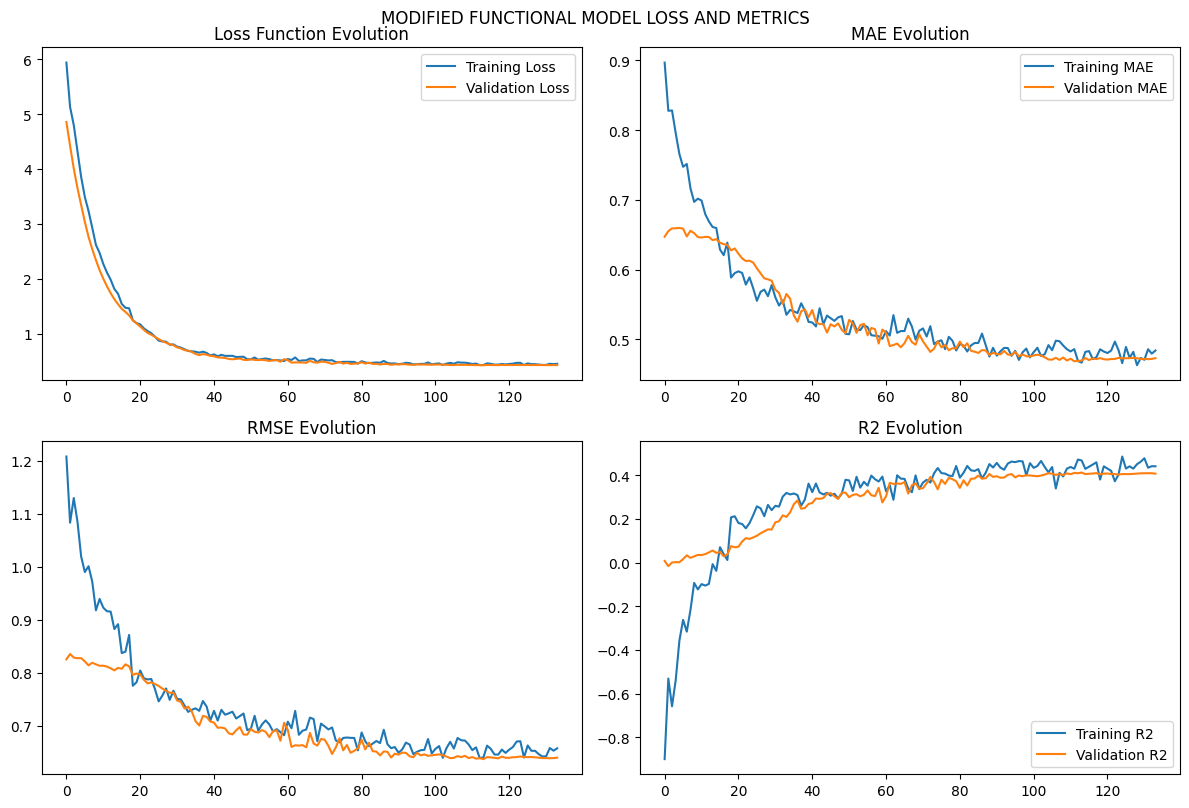

In [63]:
plt.figure(figsize = (12, 16))
plt.suptitle("MODIFIED FUNCTIONAL MODEL LOSS AND METRICS")

plt.subplot(4, 2, 1)
plt.plot(history_f_m.history["loss"], 
         label = "Training Loss")
plt.plot(history_f_m.history["val_loss"], 
         label = "Validation Loss")
plt.title("Loss Function Evolution")
plt.legend()

plt.subplot(4, 2, 2)
plt.plot(history_f_m.history["mean_absolute_error"], 
         label = "Training MAE")
plt.plot(history_f_m.history["val_mean_absolute_error"], 
         label = "Validation MAE")
plt.title("MAE Evolution")
plt.legend()

plt.subplot(4, 2, 3)
plt.plot(history_f_m.history["root_mean_squared_error"], 
         label = "Training MAPE")
plt.plot(history_f_m.history["val_root_mean_squared_error"], 
         label = "Validation MAPE")
plt.title("RMSE Evolution")

plt.subplot(4, 2, 4)
plt.plot(history_f_m.history["r_squared"], 
         label = "Training R2")
plt.plot(history_f_m.history["val_r_squared"], 
         label = "Validation R2")
plt.title("R2 Evolution")

plt.legend()
plt.tight_layout()
plt.show()

> Based on the Loss Evolution, MAE Evolution, RMSE Evolution, and R2 Evolution plots above, it can be concluded that the modified functional model does not experience overfitting, as the difference between training and validation loss is only around ±0.02.  
> The loss value (MSE) of the modified functional model (0.45) indicates that the model performs better than the [baseline functional model](#FUNCTIONAL-MODELLING-AND-TRAINING), with an RMSE of around ±0.65, which means the model’s average error is 16% of the target data.
Additionally, the R2 value of this modified model is also better than the [baseline functional model](#FUNCTIONAL-MODELLING-AND-TRAINING), although not as good as the [modified sequential model](#SEQUENTIAL-MODEL-MODIFIED), with a score of 0.44.  
> Based on my initial assumption, the poor R2 value may be caused by the wrong choice of activation function or insufficient model complexity. In this modified model, I used a different type of activation function ([*LeakyReLU*](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LeakyReLU)) and a more complex model structure (with [*L2 Regularizer*](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/L2), [*BatchNormalization*](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization), and [*Dropout*](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout)).  
However, these changes did not lead to a significant performance improvement, leaving one remaining point from my initial assumption regarding the cause of the model’s poor performance — the low correlation among features. Therefore, I will revisit this assumption in the [evaluation](#Part-D) section.

#### **MODEL EVALUATION**

##### **BASELINE SEQUENTIAL MODEL**

In [64]:
model_s.evaluate(x_test, y_test)

8/8 [==============================] - 0s 6ms/step - loss: 0.5467 - mean_absolute_error: 0.5437 - root_mean_squared_error: 0.7394 - r_squared: 0.3489


[0.5467327237129211,
 0.5437493324279785,
 0.7394137382507324,
 0.3489450216293335]

In [64]:
y_test_s = scaler_y.inverse_transform(y_test) 
y_pred_s = scaler_y.inverse_transform(model_s.predict(x_test))

mse_s = mean_squared_error(y_test_s, 
                           y_pred_s)
mae_s = mean_absolute_error(y_test_s, 
                            y_pred_s)
rmse_s = np.sqrt(mse_s)
r2_s = r2_score(y_test_s, 
                y_pred_s)

print("EVALUASI BASELINE MODEL SEQUENTIAL")
print(f"MSE: {mse_s:.4f}")
print(f"MAE: {mae_s:.4f}")
print(f"RMSE: {rmse_s:.4f}")
print(f"R2: {r2_s:.4f}")

8/8 [==============================] - 0s 2ms/step
EVALUASI BASELINE MODEL SEQUENTIAL
MSE: 120.9539
MAE: 7.9710
RMSE: 10.9979
R2: 0.5762


##### **BASELINE FUNCTIONAL MODEL**

In [65]:
model_f.evaluate(x_test, y_test)

8/8 [==============================] - 0s 9ms/step - loss: 0.4913 - mean_absolute_error: 0.5119 - root_mean_squared_error: 0.7009 - r_squared: 0.4158


[0.49129387736320496,
 0.5118874311447144,
 0.7009235620498657,
 0.4157968759536743]

In [66]:
y_test_f = scaler_y.inverse_transform(y_test) 
y_pred_f = scaler_y.inverse_transform(model_f.predict(x_test))

mse_f = mean_squared_error(y_test_f, 
                           y_pred_f)
mae_f = mean_absolute_error(y_test_f, 
                            y_pred_f)
rmse_f = np.sqrt(mse_f)
r2_f = r2_score(y_test_f, 
                y_pred_f)

print("EVALUASI BASELINE MODEL FUNCTIONAL")
print(f"MSE: {mse_f:.4f}")
print(f"MAE: {mae_f:.4f}")
print(f"RMSE: {rmse_f:.4f}")
print(f"R2: {r2_f:.4f}")

8/8 [==============================] - 0s 4ms/step
EVALUASI BASELINE MODEL FUNCTIONAL
MSE: 176.7695
MAE: 9.7097
RMSE: 13.2955
R2: 0.3806


##### **MODIFIED SEQUENTIAL MODEL**

In [67]:
model_s_m.evaluate(x_test, y_test)

8/8 [==============================] - 0s 10ms/step - loss: 0.4828 - mean_absolute_error: 0.4546 - root_mean_squared_error: 0.6528 - r_squared: 0.4821


[0.48283934593200684,
 0.45463138818740845,
 0.6527827382087708,
 0.4821181297302246]

In [68]:
y_test_s_m = scaler_y.inverse_transform(y_test) 
y_pred_s_m = scaler_y.inverse_transform(model_s_m.predict(x_test))

mse_s_m = mean_squared_error(y_test_s_m, 
                             y_pred_s_m)
mae_s_m = mean_absolute_error(y_test_s_m, 
                              y_pred_s_m)
rmse_s_m = np.sqrt(mse_s_m)
r2_s_m = r2_score(y_test_s_m, 
                  y_pred_s_m)

print("EVALUASI MODIFIED MODEL SEQUENTIAL")
print(f"MSE: {mse_s_m:.4f}")
print(f"MAE: {mae_s_m:.4f}")
print(f"RMSE: {rmse_s_m:.4f}")
print(f"R2: {r2_s_m:.4f}")

8/8 [==============================] - 0s 4ms/step
EVALUASI MODIFIED MODEL SEQUENTIAL
MSE: 153.3216
MAE: 8.6237
RMSE: 12.3823
R2: 0.4628


##### **MODIFIED FUNCTIONAL MODEL**

In [69]:
model_f_m.evaluate(x_test, y_test)

8/8 [==============================] - 0s 8ms/step - loss: 0.4465 - mean_absolute_error: 0.4611 - root_mean_squared_error: 0.6523 - r_squared: 0.4964


[0.4465356171131134,
 0.46109986305236816,
 0.6523298025131226,
 0.49637576937675476]

In [70]:
y_test_f_m = scaler_y.inverse_transform(y_test) 
y_pred_f_m = scaler_y.inverse_transform(model_f_m.predict(x_test))

mse_f_m = mean_squared_error(y_test_f_m, 
                             y_pred_f_m)
mae_f_m = mean_absolute_error(y_test_f_m, 
                              y_pred_f_m)
rmse_f_m = np.sqrt(mse_f_m)
r2_f_m = r2_score(y_test_f_m, 
                  y_pred_f_m)

print("EVALUASI MODIFIED MODEL FUNCTIONAL")
print(f"MSE: {mse_f_m:.4f}")
print(f"MAE: {mae_f_m:.4f}")
print(f"RMSE: {rmse_f_m:.4f}")
print(f"R2: {r2_f_m:.4f}")

8/8 [==============================] - 0s 4ms/step
EVALUASI MODIFIED MODEL FUNCTIONAL
MSE: 153.1089
MAE: 8.7464
RMSE: 12.3737
R2: 0.4635


##### **SUMMARY**

> Based on the evaluation results of the four models I created, it turns out that the baseline sequential model actually has more optimal loss, MAE, RMSE, and R2 values during testing compared to the other models.  
> This indicates that the baseline sequential model tends to be more stable and not overfit, whereas the modified sequential model, which showed more optimal loss and R2 values during training and validation, did not perform better than the baseline sequential model, suggesting the possibility of overfitting on the training set, and even on the validation set.  
> Nevertheless, the overall performance of all models is still lacking, as none of the R2 values exceed 60%, meaning the models only capture up to 60% of the variance in the target data (productivity_score).  
> One insight I gained is that modifying the model architecture does indeed affect model performance, but the impact is not significant. This may be due to low correlation between the features and the target, making it difficult for the model to capture meaningful patterns.  
> As a potential solution, additional data could be recorded. For example, in the context of team productivity in a garment company, this could include the number of work revisions, team members on sick leave, or other relevant factors closely related to productivity.